In [1]:
# Navigate to appropriate directory
import os
while os.path.split(os.getcwd())[1] != "patchmatch":
    os.chdir("..")
    if os.getcwd() == "/":
        raise ValueError()

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from time import time
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map
import cv2 as cv

import patchmatch as pm
import detection as dt

## Functions

In [2]:
RES_DIR_1 = "results/results1/"

def gradn(im):
    """
    Compute the norm of the gradient of the image im of shape (m,n,3). The return is of size (m-1,n-1)
    """
    grad = np.sqrt(np.diff(im, axis=0)[:, :-1]**2 + np.diff(im, axis=1)[:-1, :]**2)
    return grad

class Result:
    def __init__(self, filename):
        title = filename[:10]
        im = Image.open(f"data/CMFD_DB/{title}_copy.png")
        self.im = np.array(im)
        gt = Image.open(f"data/CMFD_DB/{title}_gt.png")
        self.gt = np.array(gt) > 0
        a = np.load(RES_DIR_1 + title + "_results.npz")
        for key in a.files:
            setattr(self, key, a[key])
    
    def compute_mask(self):
        self.mask, _ = dt.compute_mask(self.vect_field, self.m, self.n, self.p)
        return self
    
    def compute_mask2(self):
        self.mask = dt.compute_mask2(self.vect_field, self.m, self.n, self.p)
        return self
    
    def compute_intermediate_mask(self):
        """
        Compute the mask of copy-move with the vect_field. It return the computed mask and the number of detection.
        """
        m, n, p = self.m, self.n, self.p
        
        r = p
        th = 0.5
        th_comp = 0.05
        s = 2 * p

        #Compute the gradn of x and y displacement map
        vx = gradn(self.vect_field[..., 0])
        vy = gradn(self.vect_field[..., 1])

        #Compute a first mask
        mask_0 = np.zeros((m, n))
        u = (np.mean(vx) + np.mean(vy)) / 100
        mask_0[:-1, :-1] = 1 * (vy < u) * (vx < u)

        #Filter a big part of the noise
        kernel = np.ones((r, r))
        kernel = kernel / np.sum(kernel)
        mask_1 = cv.filter2D(mask_0, -1, kernel)
        mask_2 = 1 * (mask_1 > th)

        return mask_2
    
        #look at connexe component to keep just biggest ones
        mask_3 = np.uint8((mask_2))
        N, component = cv.connectedComponents(mask_3)
        white_pixel = np.sum(mask_2)

        liste_component = []
        for i in range(1,N):
            #we keep just component which as more than 5% of white pixels
            if np.sum(1 * (component == i)) / white_pixel > th_comp:
                liste_component.append(i)
        mask_4 = np.zeros((m, n))
        number_detection = len(liste_component) // 2
        for i in liste_component:
            mask_4 += 1 * (component == i)
    
    def compute_coherence(self):
        m, n = self.m, self.n
        ii, jj = np.meshgrid(np.arange(m), np.arange(n), indexing="ij")
        ij = np.stack((ii, jj), axis=-1)
        end_points = ij + self.vect_field
        end_points2 = end_points[end_points[..., 0], end_points[..., 1]]
        back_and_forth_distance = np.max(np.abs(end_points2 - ij), axis=-1)
        coherence = np.minimum(back_and_forth_distance, 3)
        return coherence
    
    def print_res(self):
        im, gt, mask = self.im, self.gt, self.mask
        # Plot image
        plt.imshow(im)
        plt.show()
        # Show gt and mask
        fig, ax = plt.subplots(1, 2, figsize=(15, 8))
        ax[0].imshow(gt, cmap="gray")
        ax[1].imshow(mask, cmap="gray")
        plt.show()
        # Compute F measure
        TP = mask * gt
        FP = mask * (gt < 1)
        FN = (mask < 1) * gt
        fscore = 2 * np.sum(TP) / (2 * np.sum(TP) + np.sum(FN) + np.sum(FP))
        print("F score:", fscore)
        # Vect field
        fig, ax = plt.subplots(1, 2, figsize=(15, 8))
        axim = ax[0].imshow(self.vect_field[..., 0])
        fig.colorbar(axim, ax=ax[0], shrink=0.5)
        axim = ax[1].imshow(self.vect_field[..., 1])
        fig.colorbar(axim, ax=ax[1], shrink=0.5)
        plt.show()
        # Dist field
        plt.imshow(self.dist_field)
        plt.colorbar()
        plt.show()
        # Coherence
        plt.imshow(self.compute_coherence())
        plt.show()
        
        return self

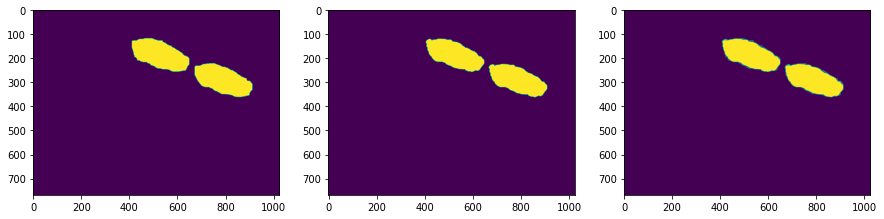

0.9647819893038138


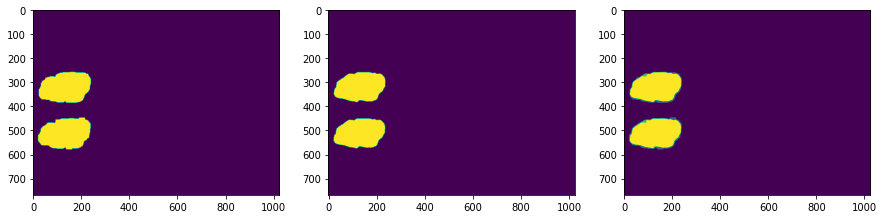

0.9530078415660237


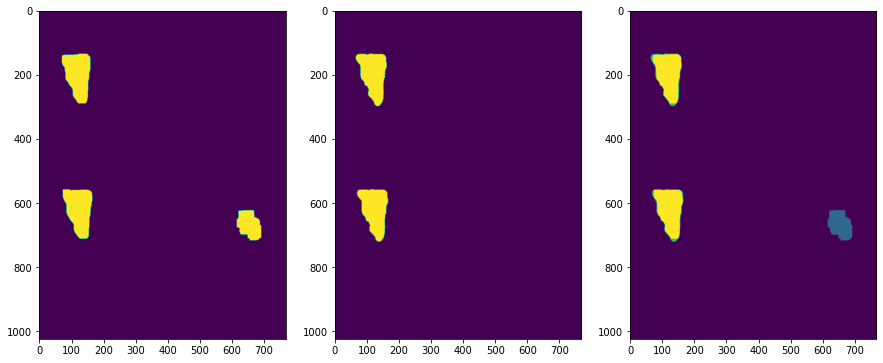

0.8491889426939697


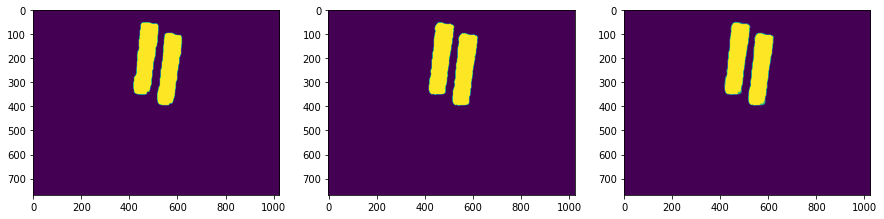

0.9748161091892275


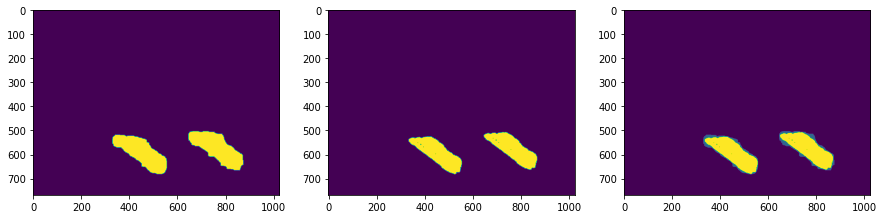

0.90374531835206


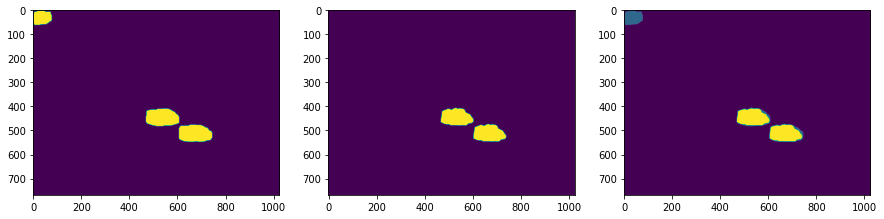

0.8363666264663963


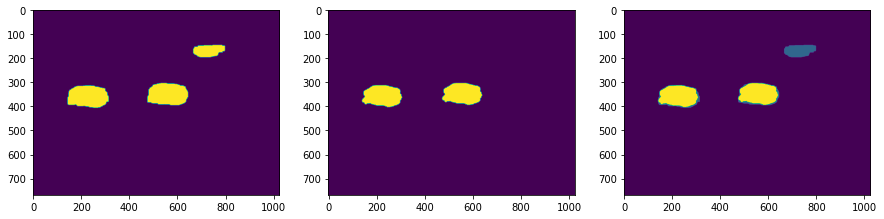

0.848015873015873


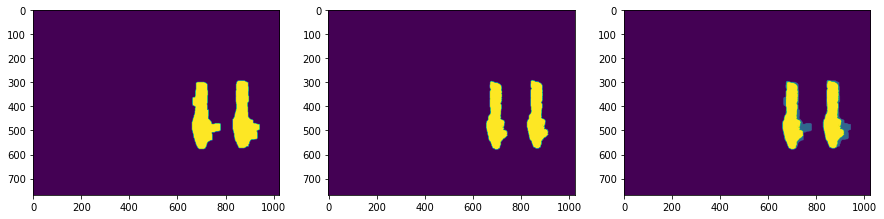

0.8788993857106382


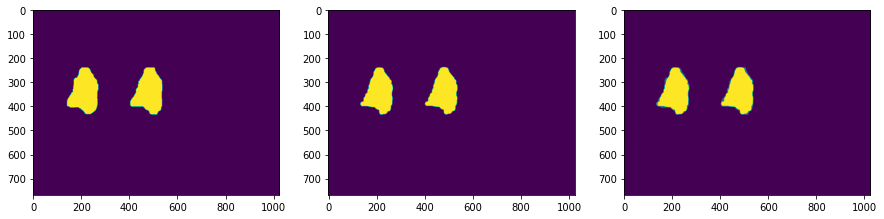

0.9623704672841616


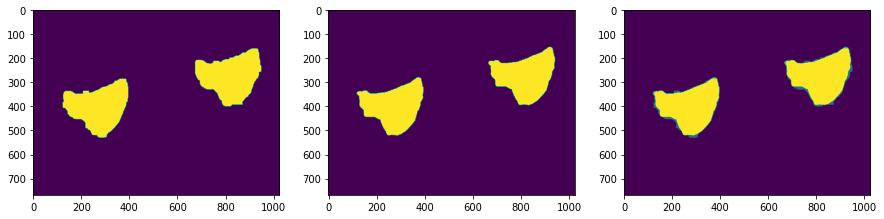

0.962923078849501


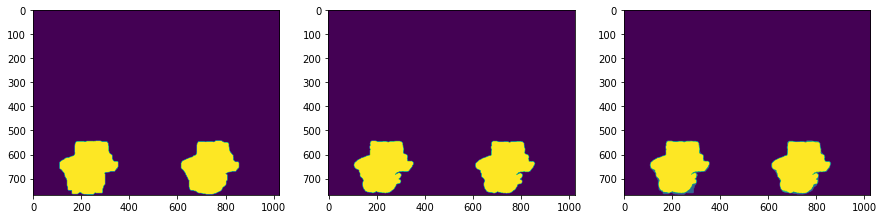

0.9681421701628629


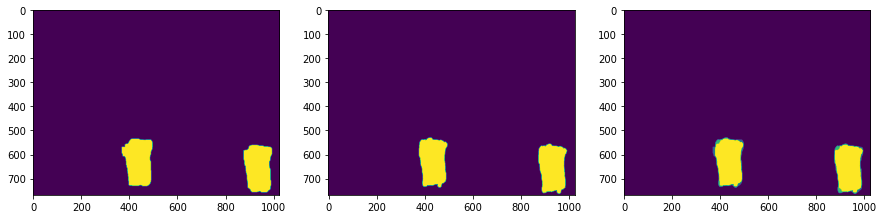

0.9515148431736664


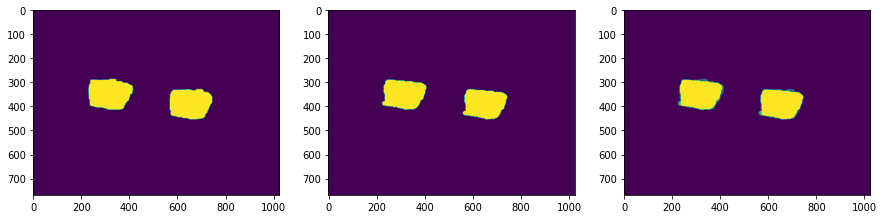

0.957565838017682


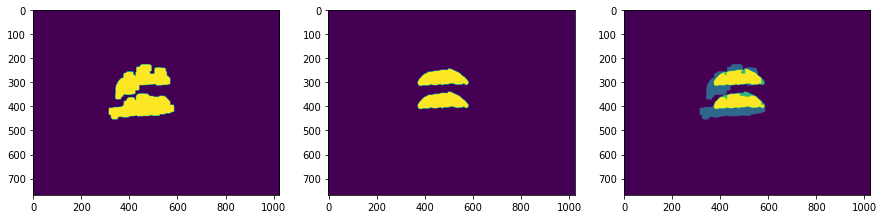

0.6679269722907805


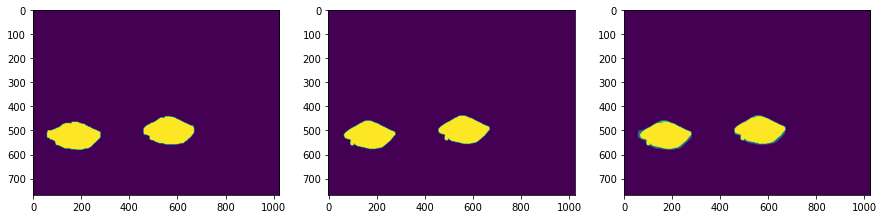

0.9498911931285938


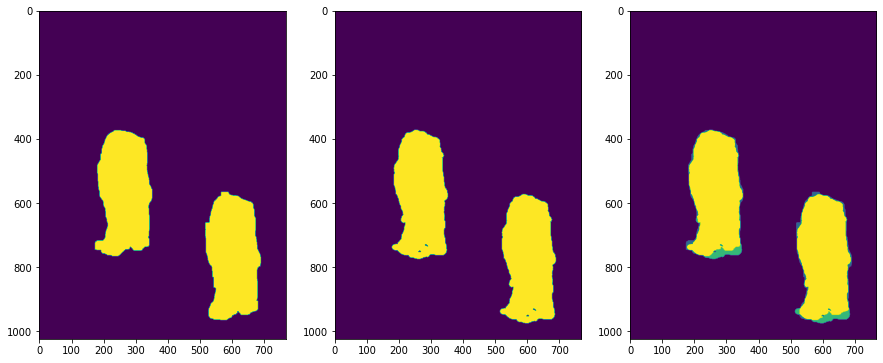

0.9563082737761639


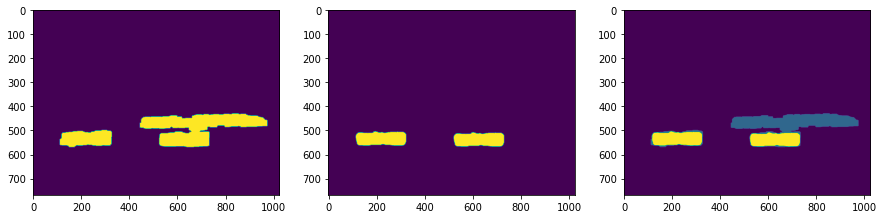

0.5907490656989655


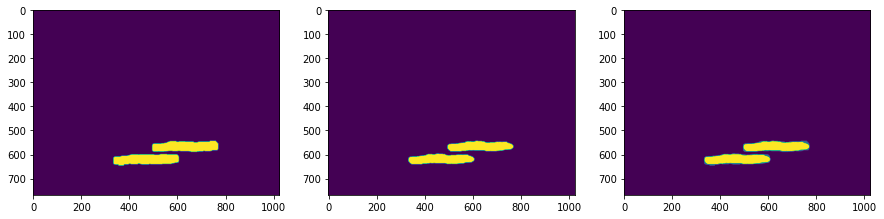

0.9314979351770742


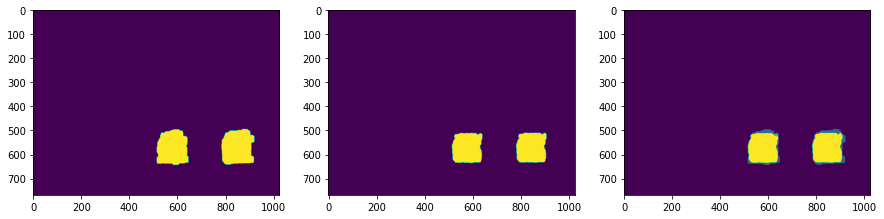

0.9078132788756854


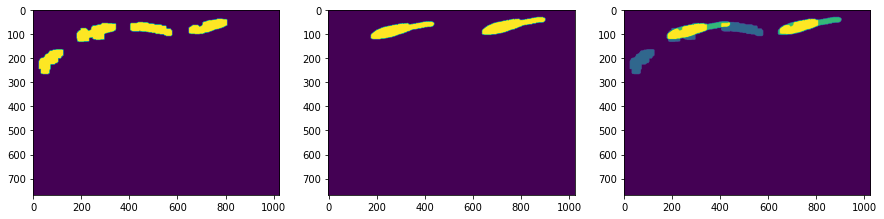

0.5849832402234637


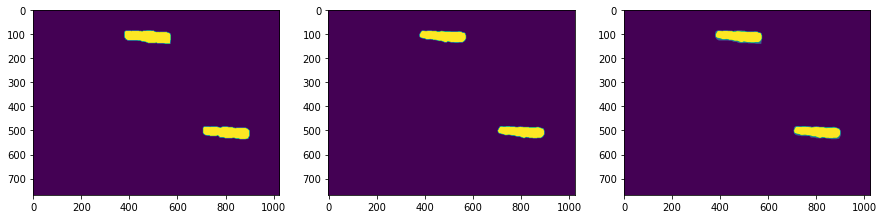

0.9265756570553713


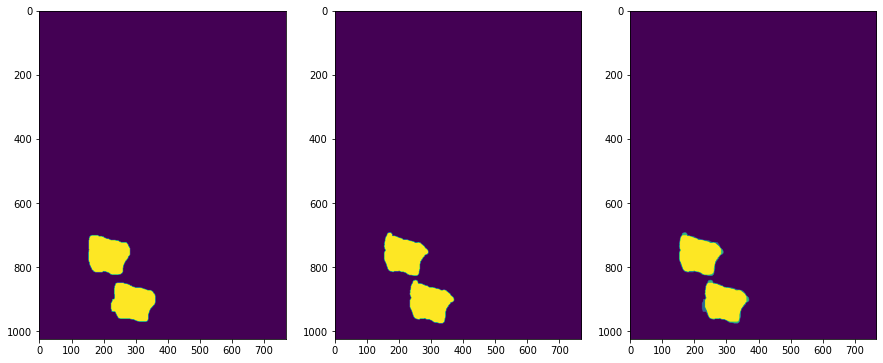

0.960959387282072


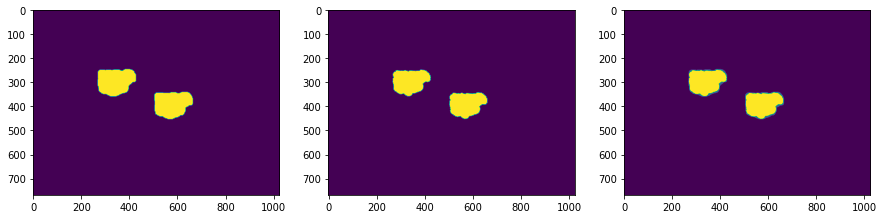

0.9429388930400394


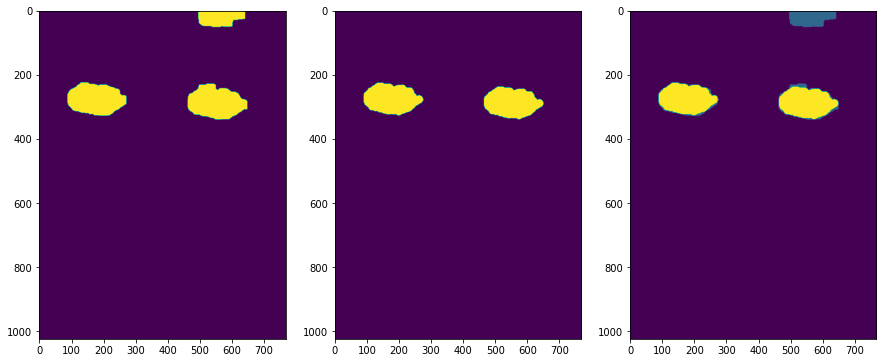

0.8633187425387983


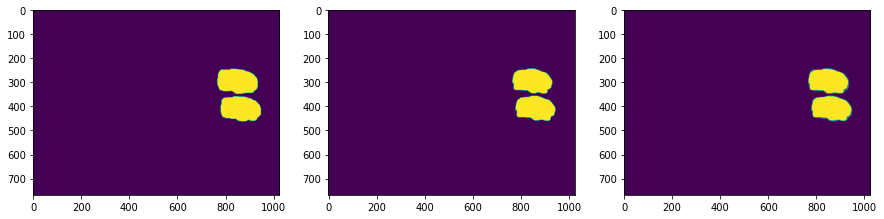

0.9595224904837644


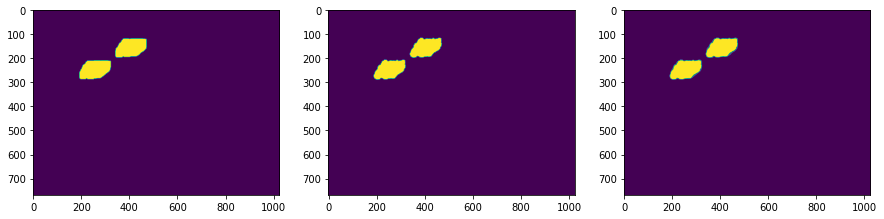

0.9546686150942247


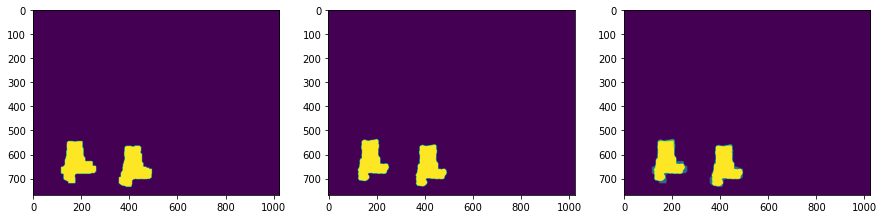

0.9321110098464948


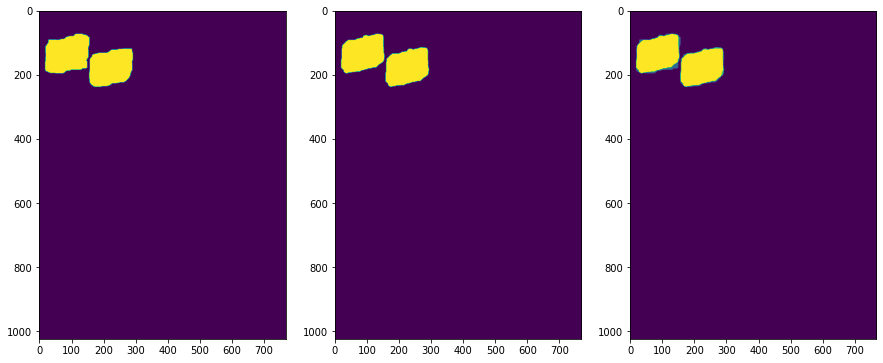

0.9603865820082036


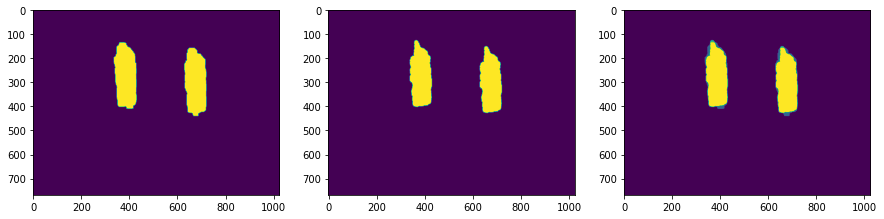

0.9477942873804809


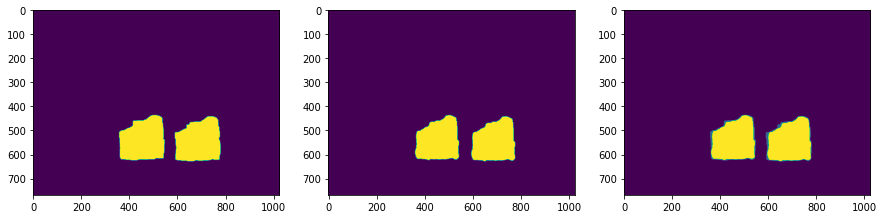

0.9604820828266933


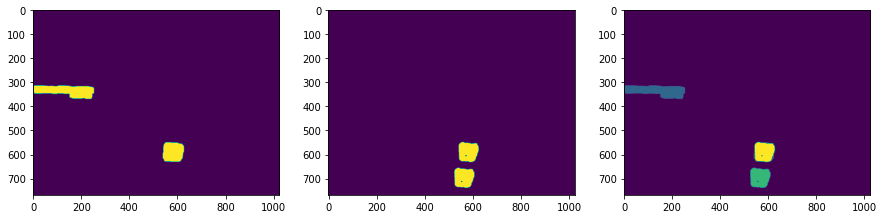

0.4142299846104291


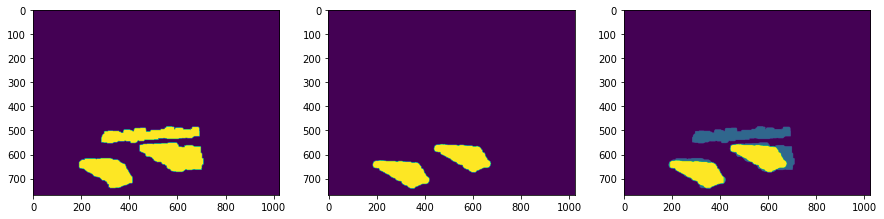

0.6992020455847991


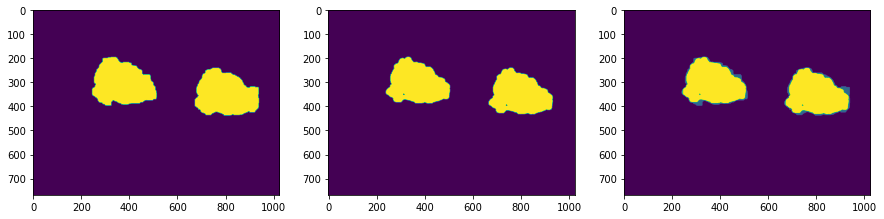

0.9481297125156387


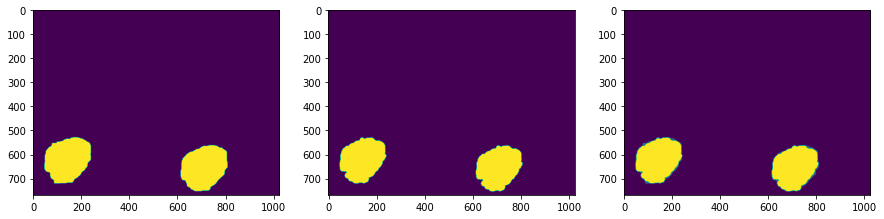

0.9697844582585238


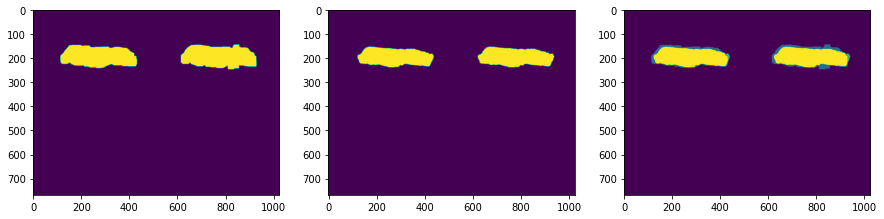

0.8941189586933497


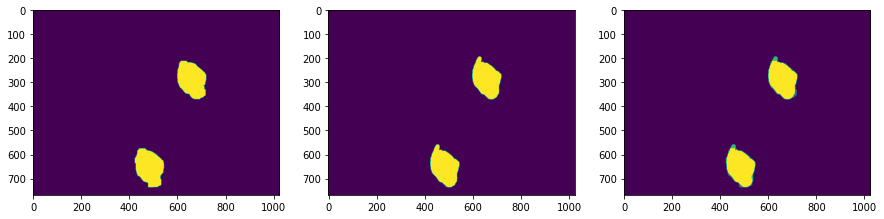

0.957179194807473


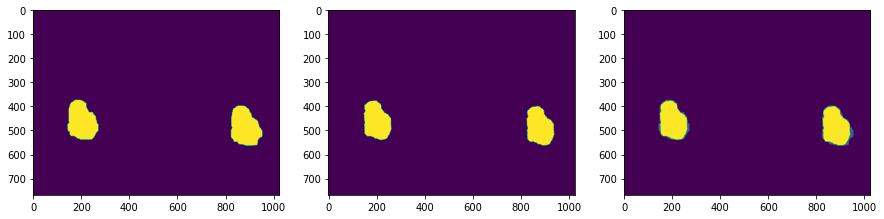

0.9392601412247192


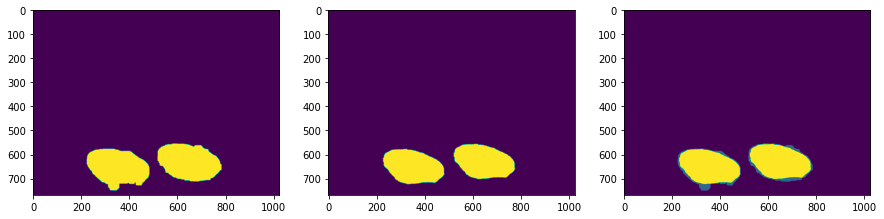

0.9316135921844105


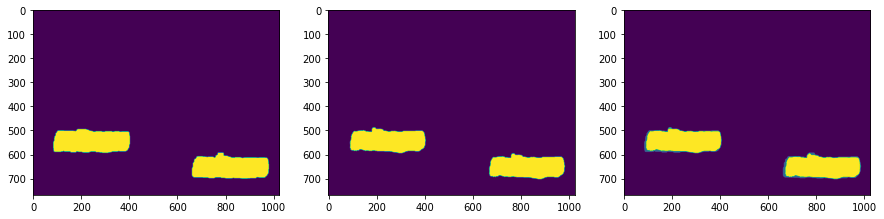

0.954164834445141


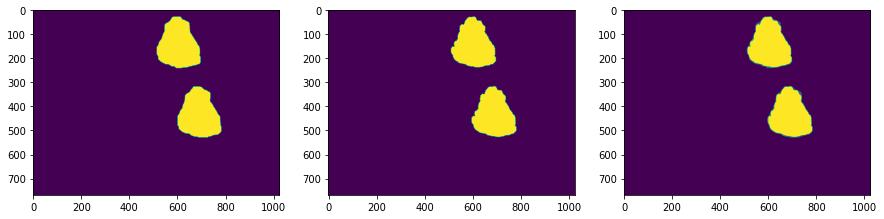

0.9744726047465573


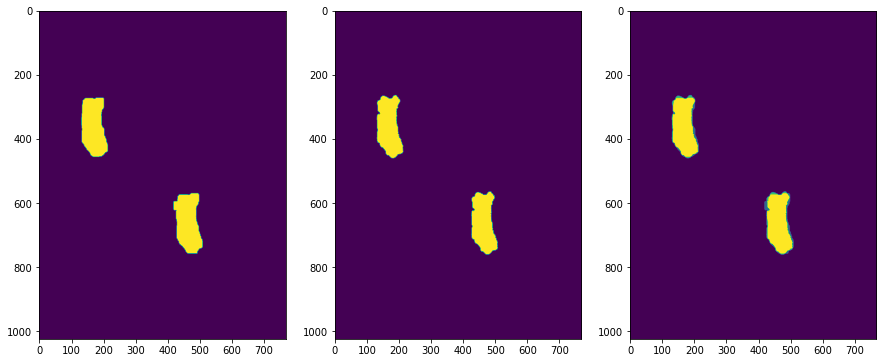

0.9360174056314823


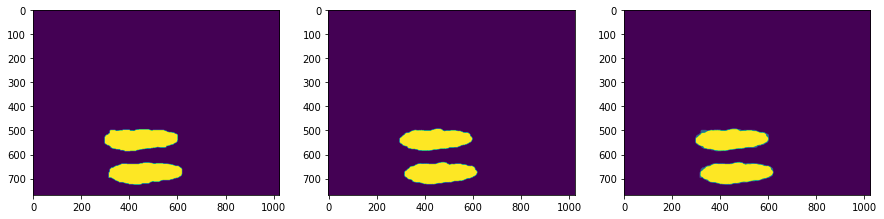

0.9671419274684967


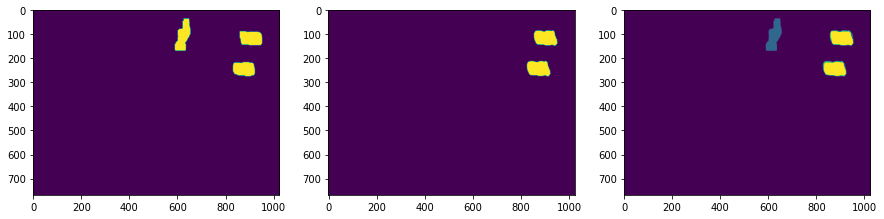

0.7327129226057251


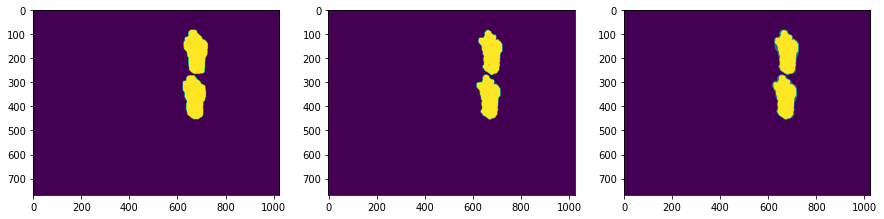

0.9430018873547233


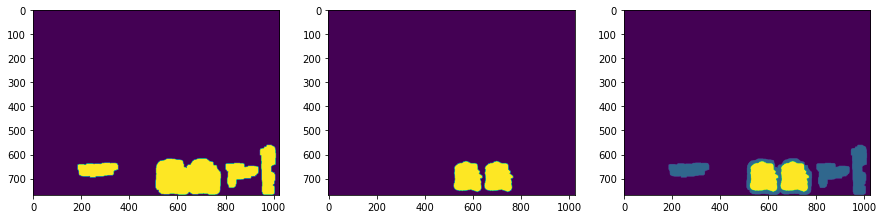

0.5490471869328494


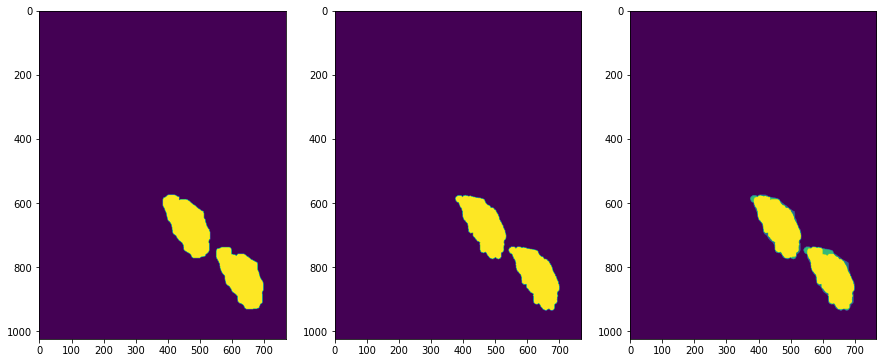

0.9510190803524703


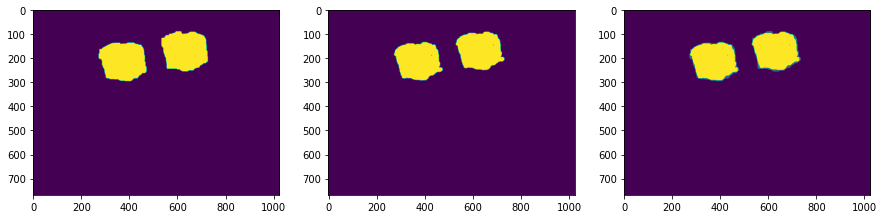

0.960716678164712


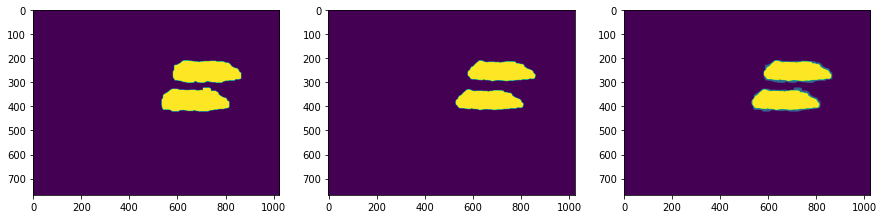

0.9152796742566828


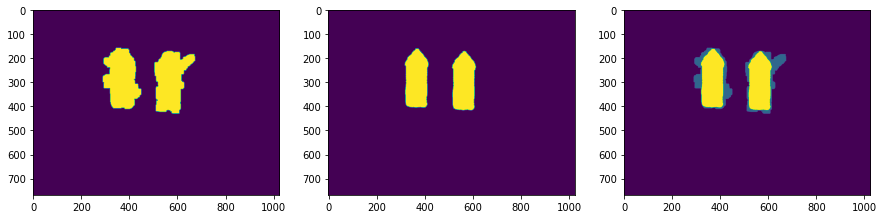

0.8226883040513355


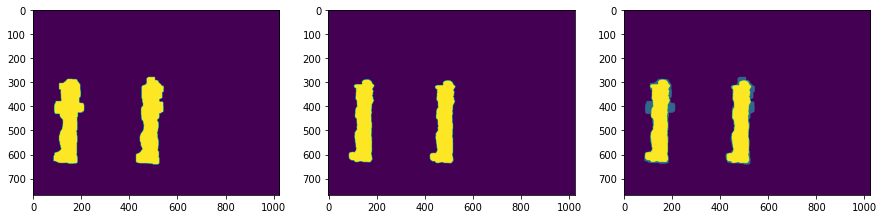

0.9025813933092313


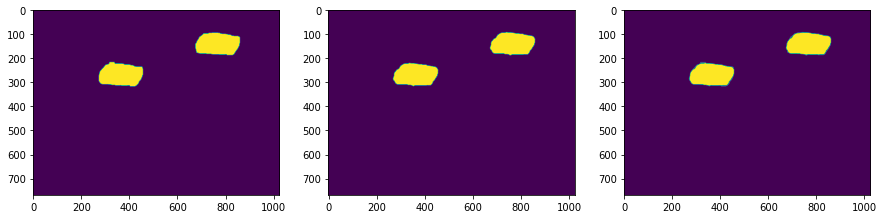

0.9734334089718973


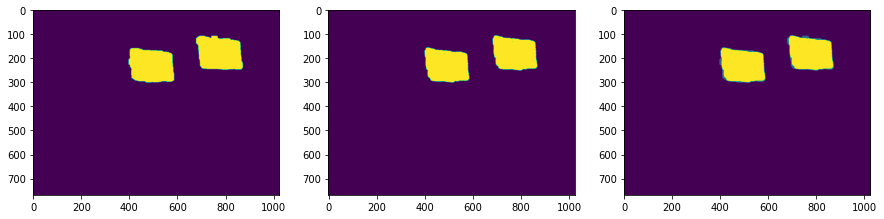

0.9695650732979088


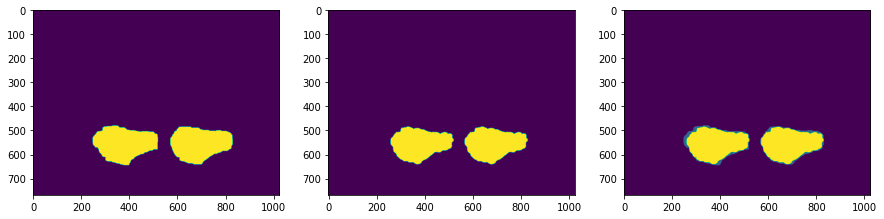

0.946635649694786


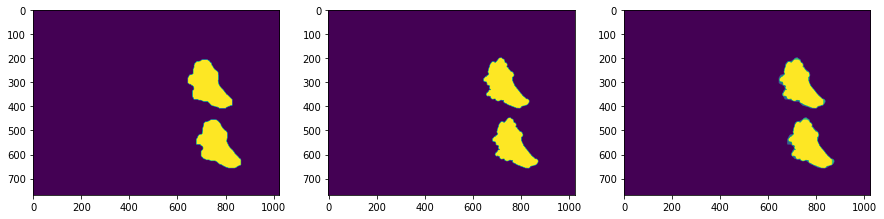

0.9560519679204466


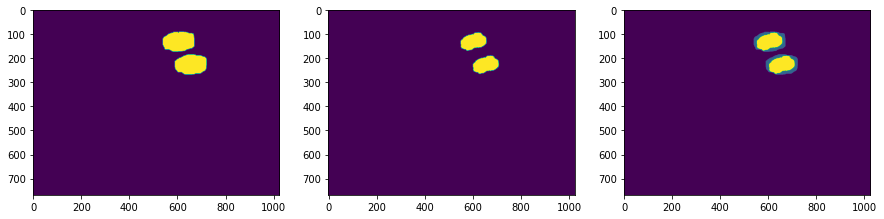

0.7728293287758453


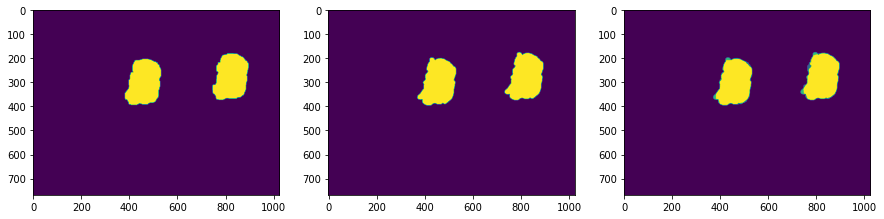

0.9709012856542232


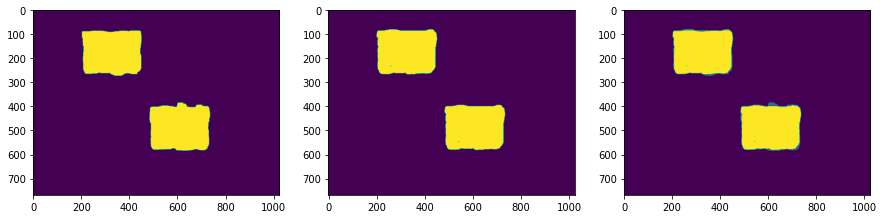

0.974970943278979


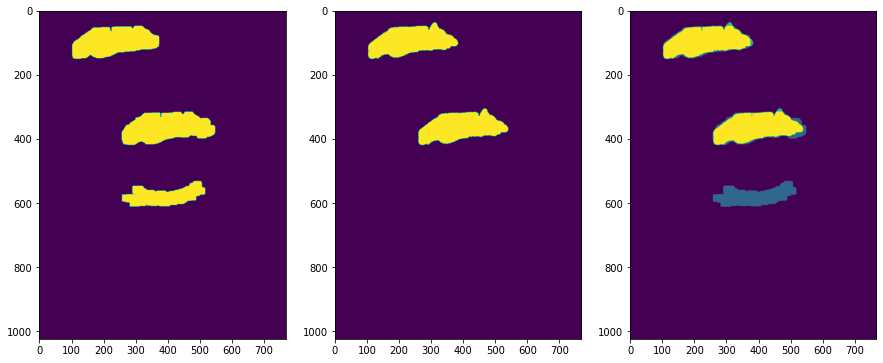

0.8224792047068371


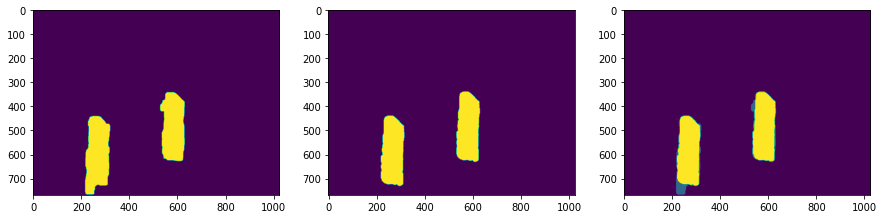

0.9430724823604875


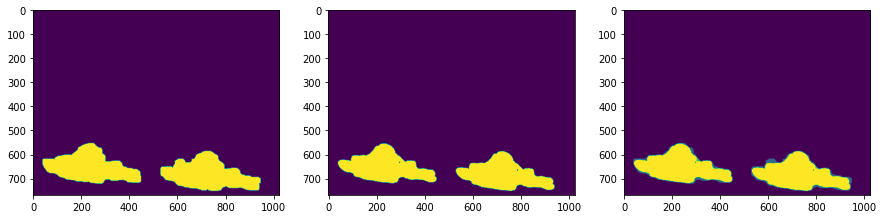

0.9489118043999528


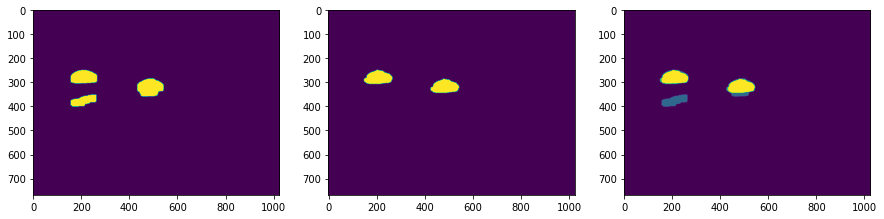

0.7694535775794583


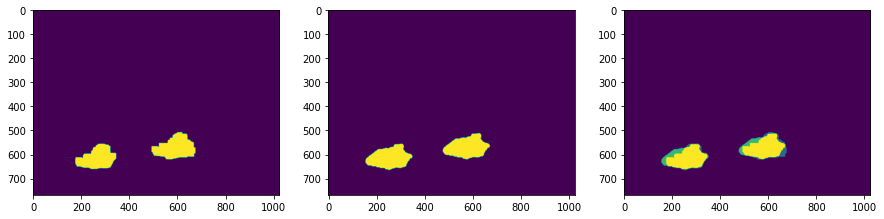

0.8791919346507757


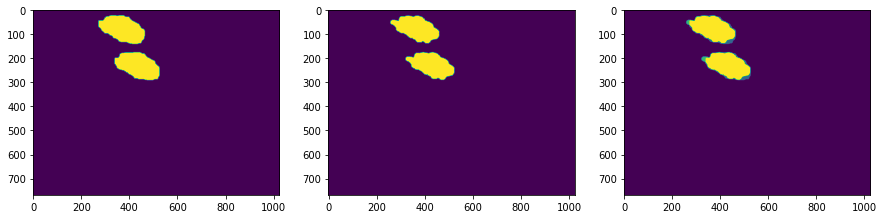

0.942112284053293


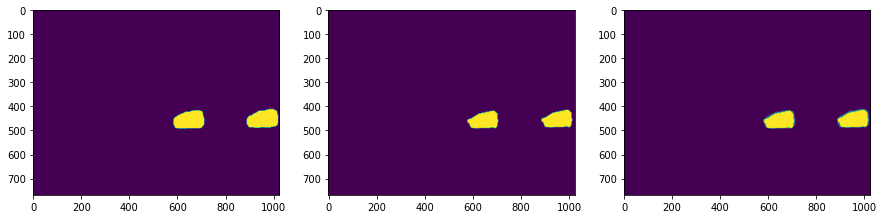

0.9216773183774618


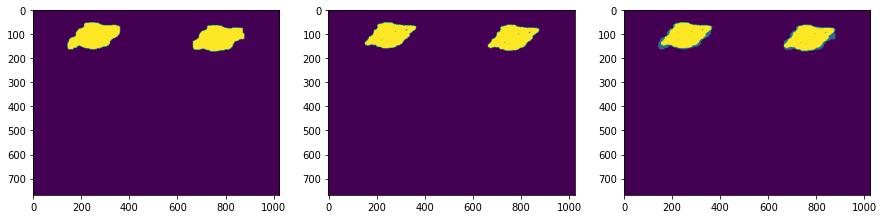

0.9140392908481073


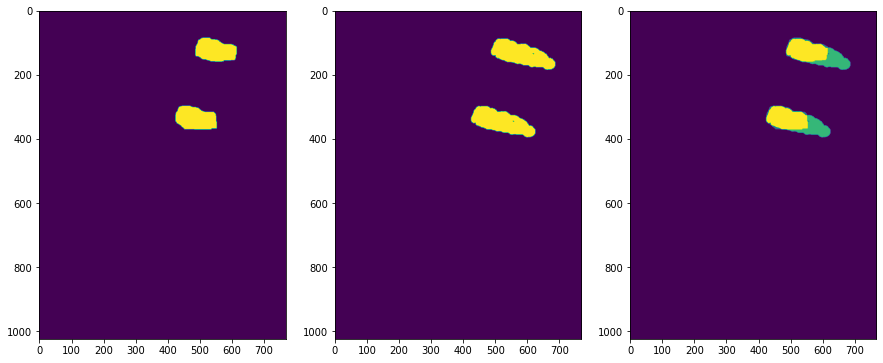

0.7633408818436126


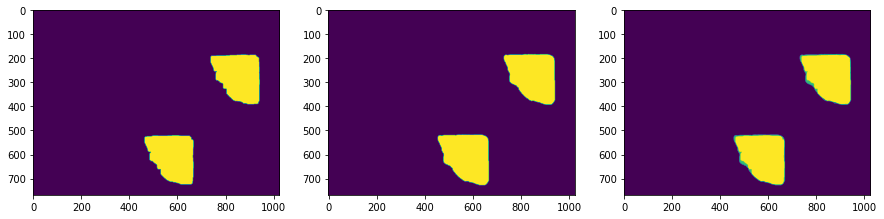

0.9665620410202119


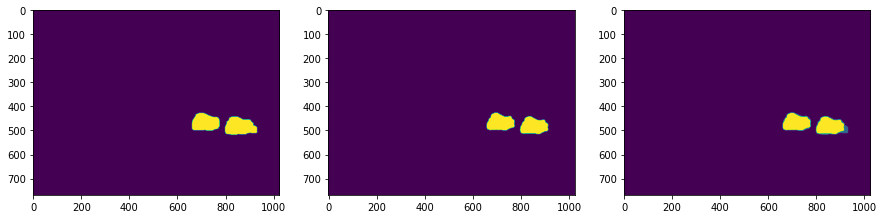

0.9313959372515


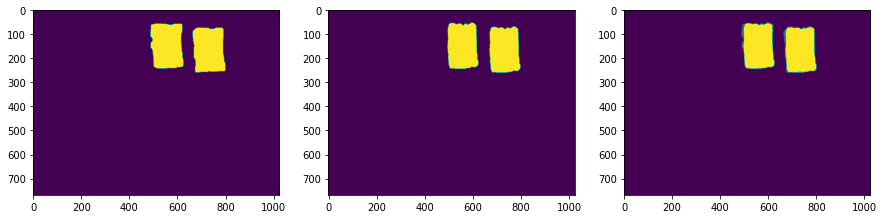

0.9651165389170707


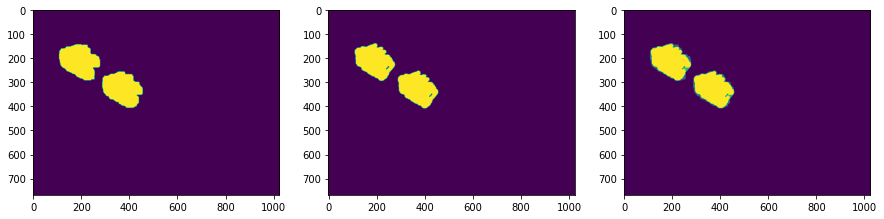

0.9452513324426439


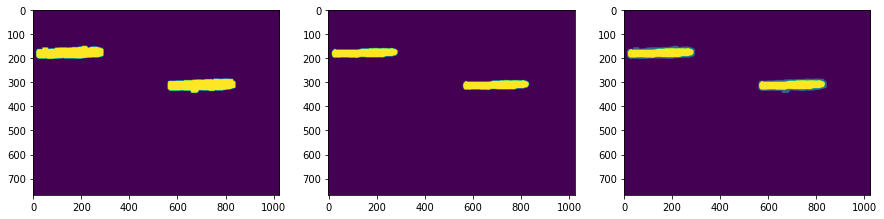

0.8493901603398657


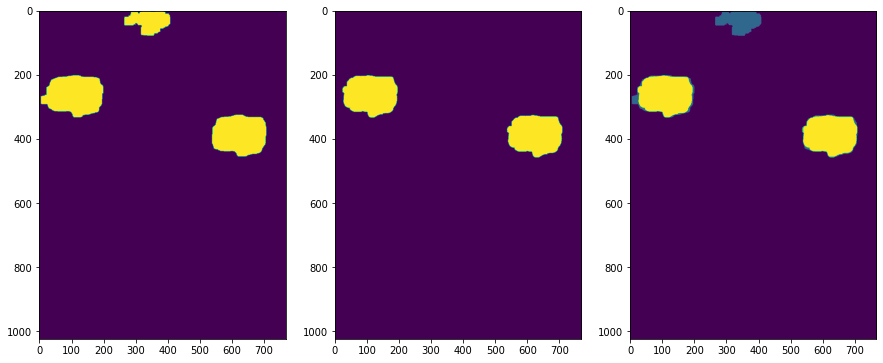

0.8730137138758702


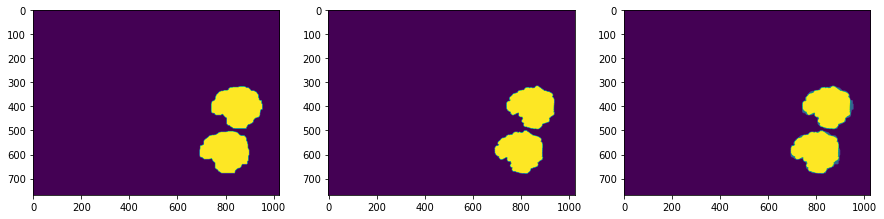

0.960861210243539


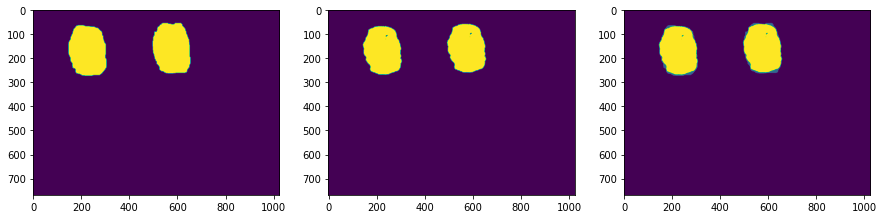

0.9619001327326092


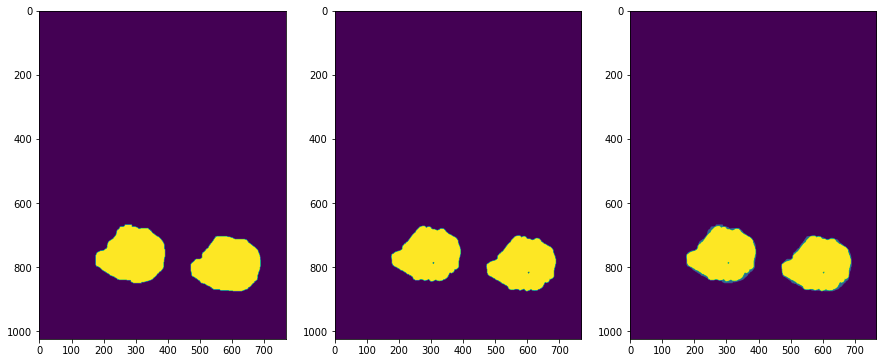

0.964302791775481


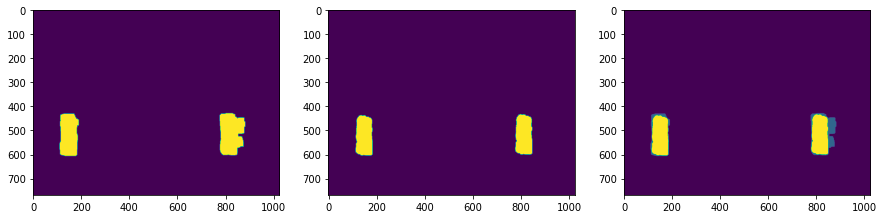

0.8662485444033586


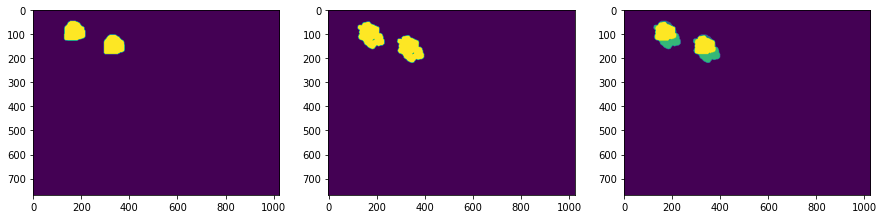

0.7660981552384267


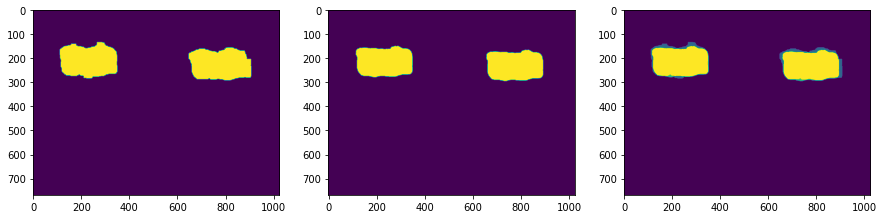

0.9295761963941571


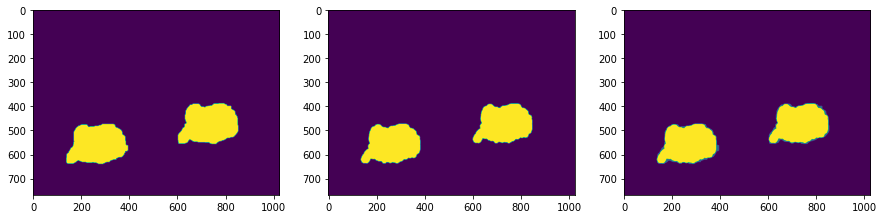

0.9641689246005792


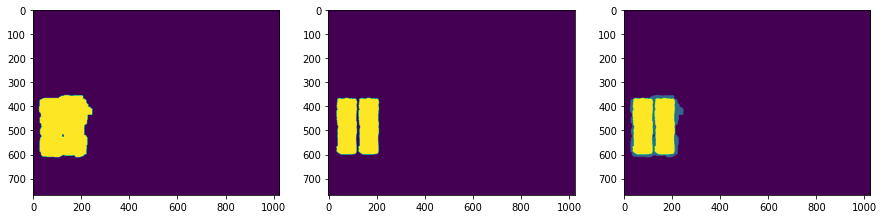

0.8731011809692575
Mean: 0.8957160184291266


In [3]:
filenames = [f for f in os.listdir(RES_DIR_1) if f[:2] == "TP"]
fscores = []

for filename in filenames:
    res = Result(filename).compute_mask()
    gt = res.gt
    mask = res.mask
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 9))
    ax[0].imshow(mask)
    ax[1].imshow(gt)
    ax[2].imshow(2 * gt + mask)
    plt.show()
    # Compute F measure
    TP = mask * gt
    FP = mask * (gt < 1)
    FN = (mask < 1) * gt
    
    fscore = 2 * np.sum(TP) / (2 * np.sum(TP) + np.sum(FN) + np.sum(FP))
    fscores.append(fscore)
    print(fscore)
    
print("Mean:", np.mean(fscores))

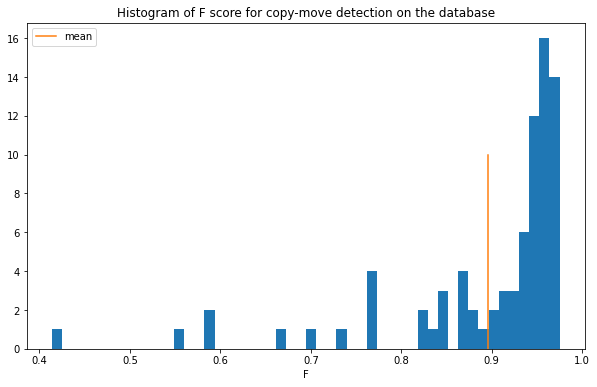

In [5]:
F = fscores
plt.figure(figsize=(10,6))
plt.title("Histogram of F score for copy-move detection on the database")
plt.xlabel("F")
plt.hist(F, bins=50)
plt.plot([np.mean(F), np.mean(F)], [0, 10], label="mean")
plt.legend()
plt.show()

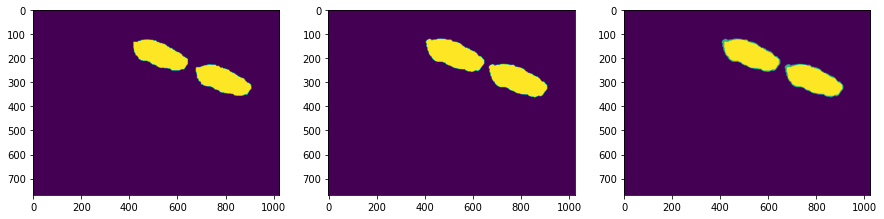

0.9424750098436449


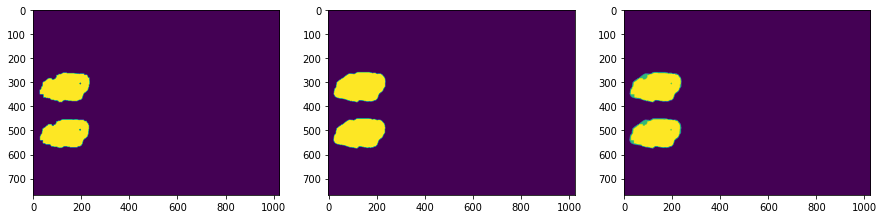

0.9485005377554339


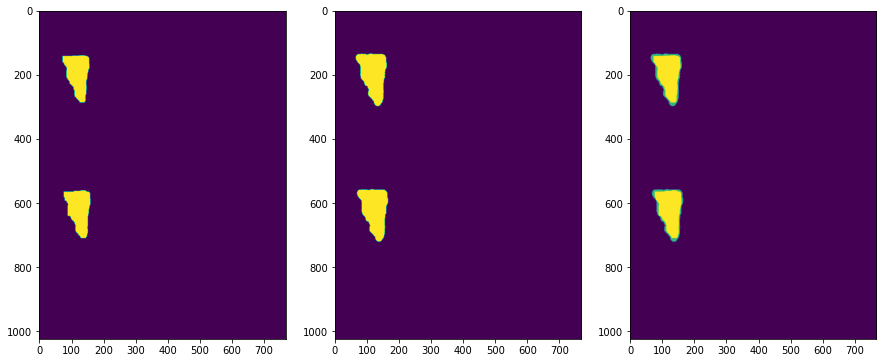

0.8915695310382218


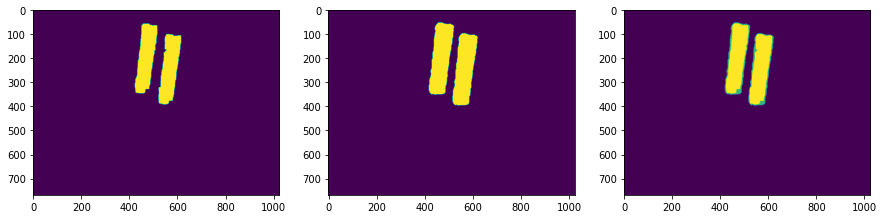

0.9080552256152854


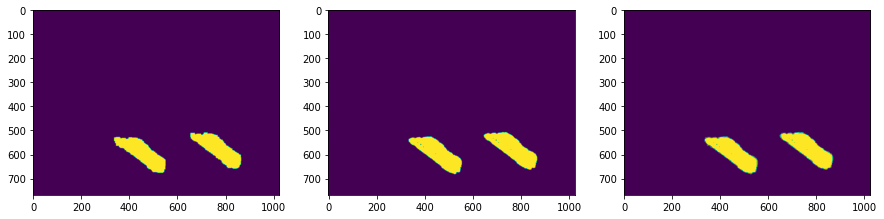

0.9544901115535227


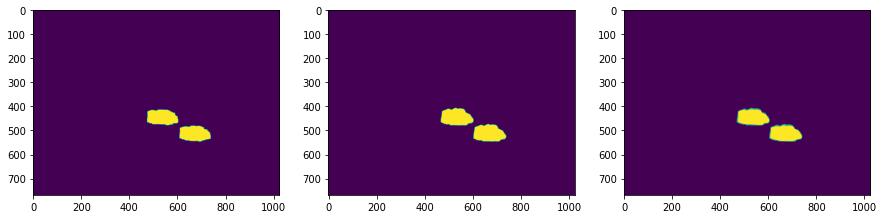

0.9310872894333844


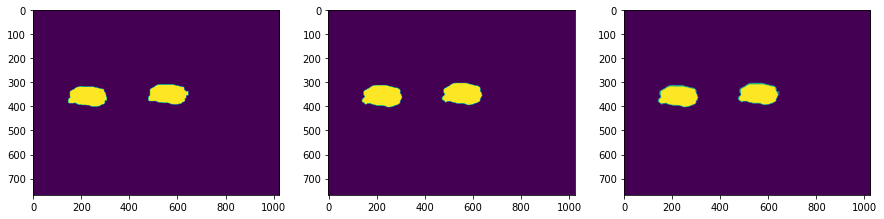

0.9417568075740482


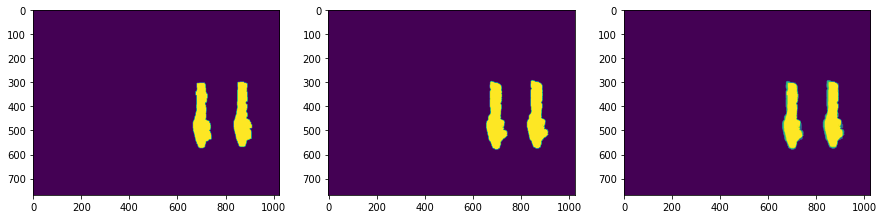

0.9081415586927093


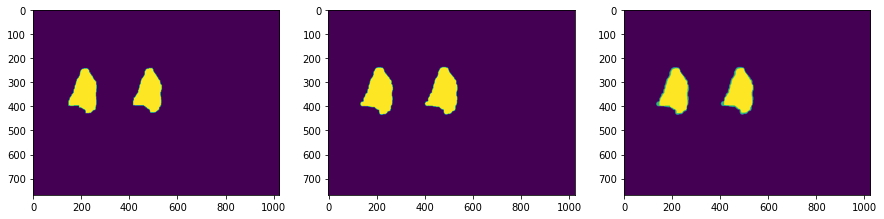

0.9310525454247831


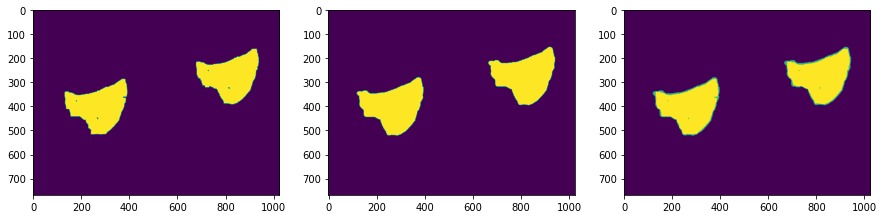

0.9506724640812358


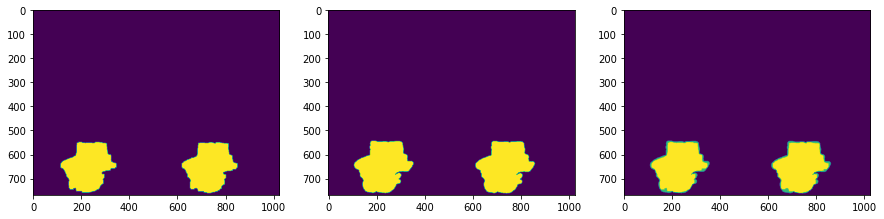

0.9438793379684485


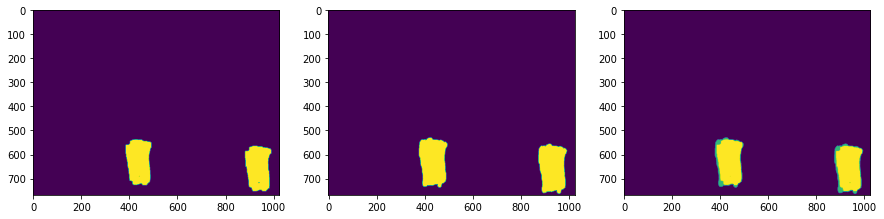

0.9175409813464216


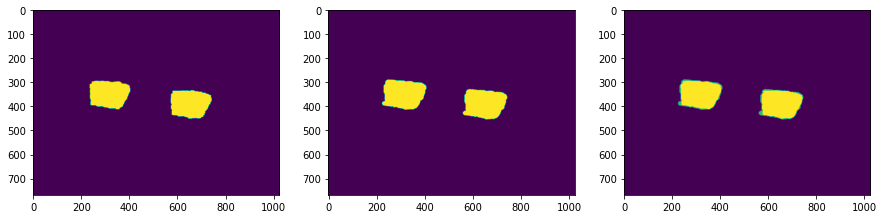

0.9479406109496754


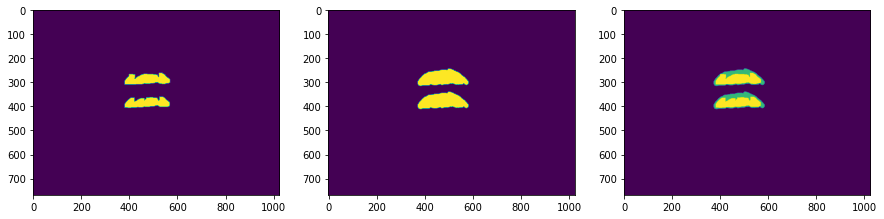

0.7673287631100955


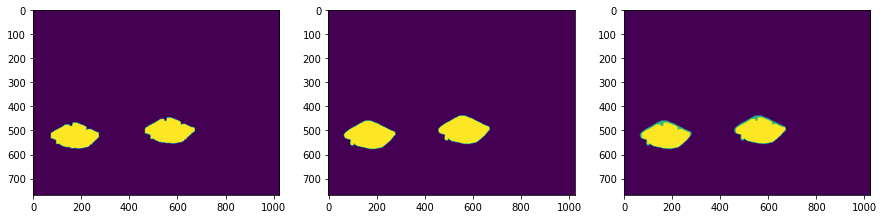

0.9339247379719662


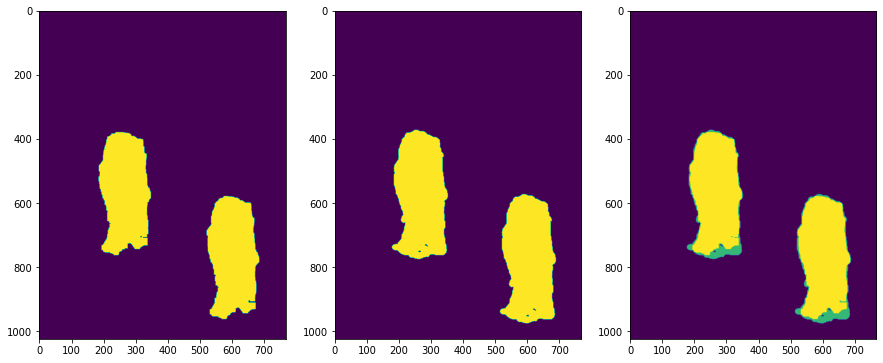

0.9406439323272096


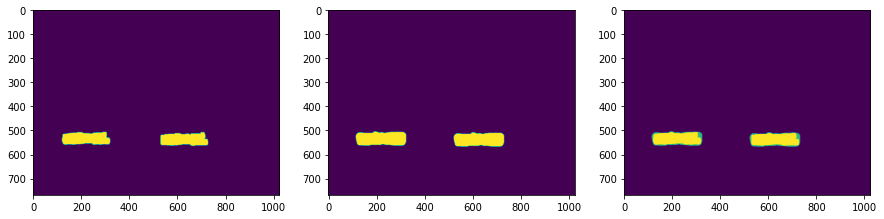

0.9070379193964662


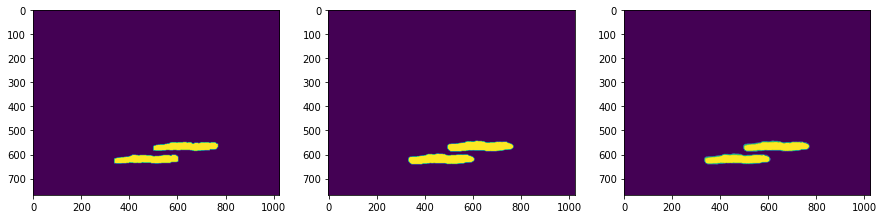

0.9054576956396189


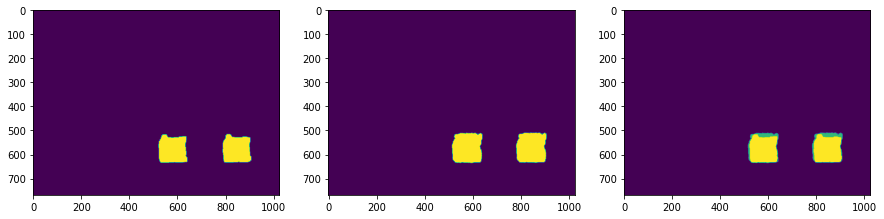

0.9084849747211755


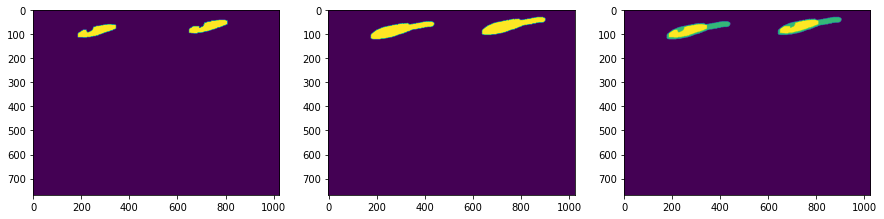

0.67634930482064


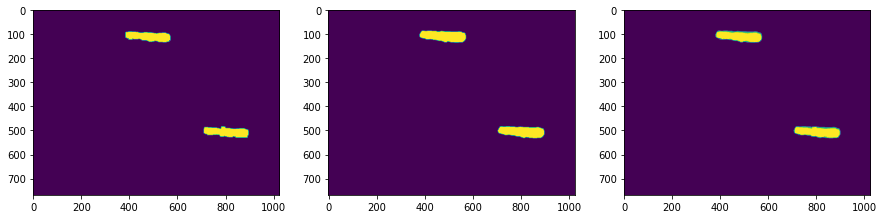

0.9069097538742024


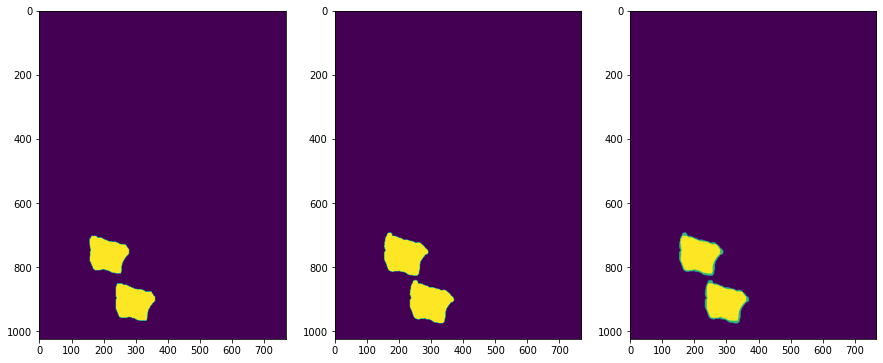

0.9143596150895421


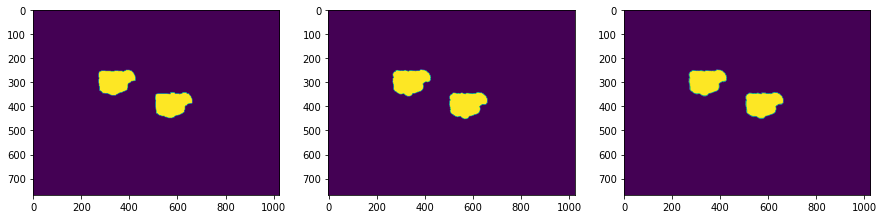

0.9672325774664609


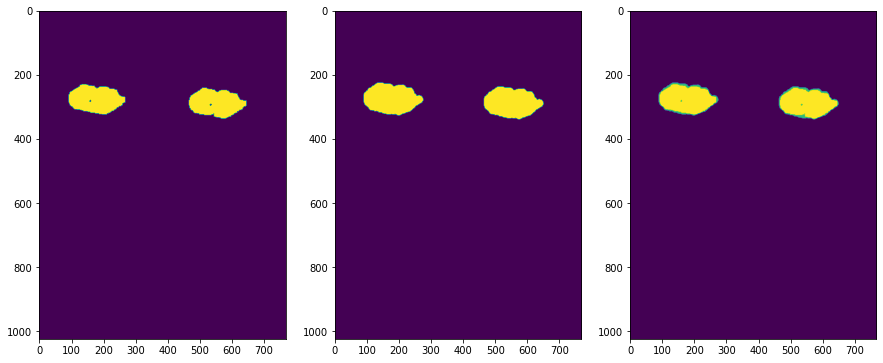

0.9347486731189509


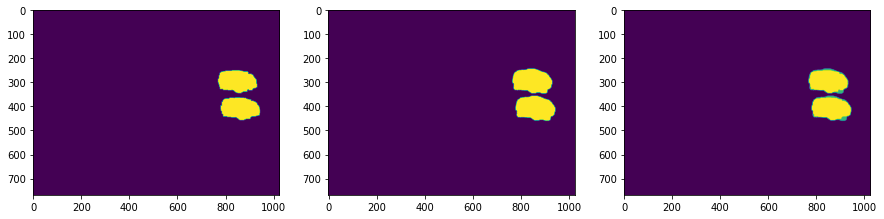

0.9383443967200312


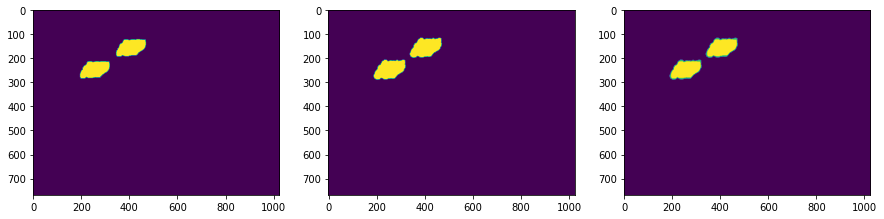

0.9174380109452064


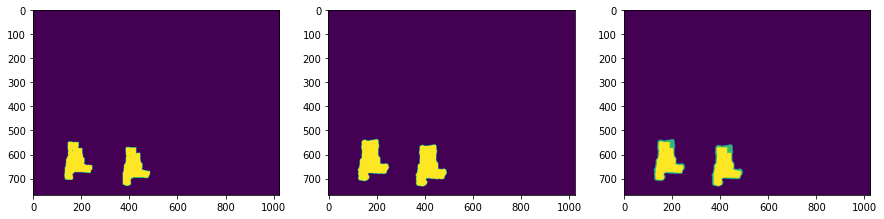

0.8703618489855679


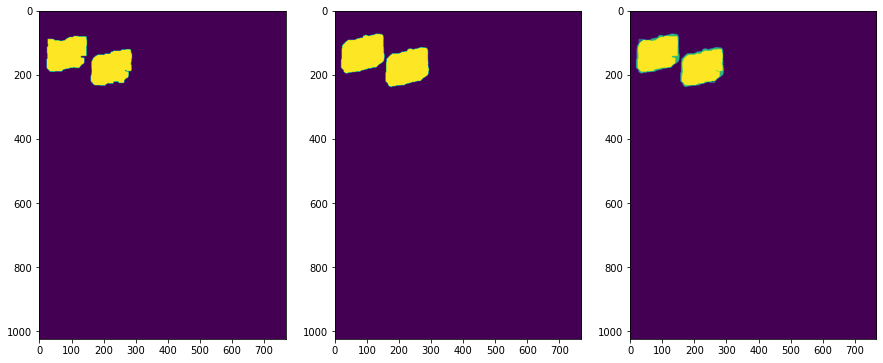

0.9276296991713947


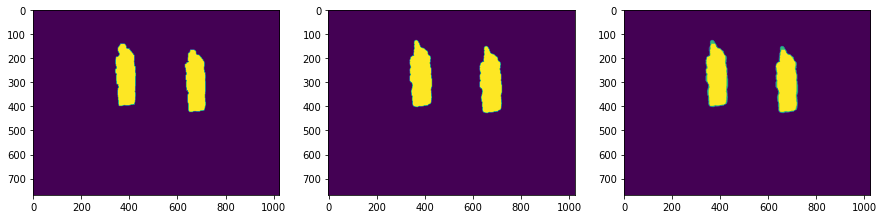

0.9350026638252531


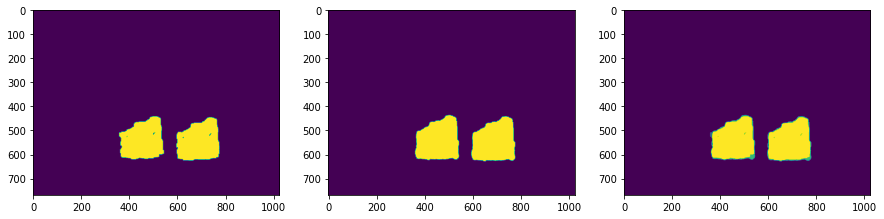

0.958758841151192


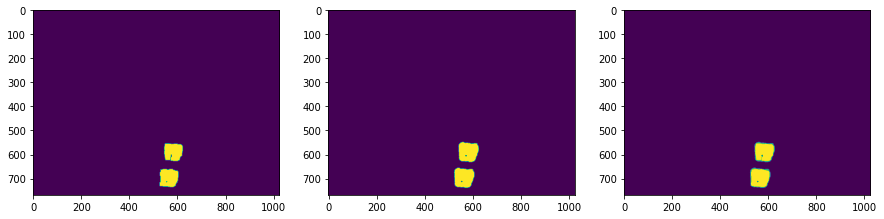

0.9217727817193403


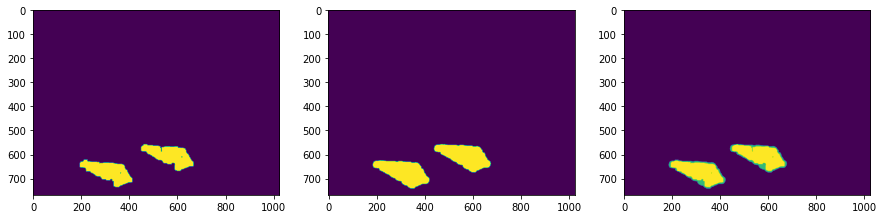

0.8907462482480429


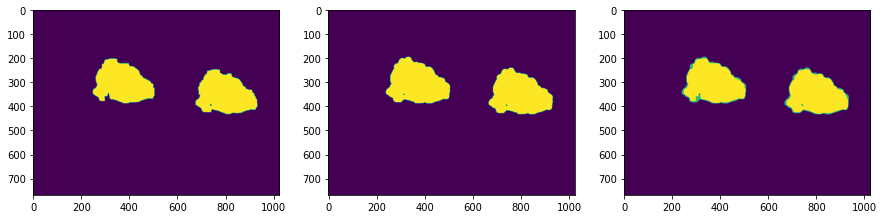

0.959269939770031


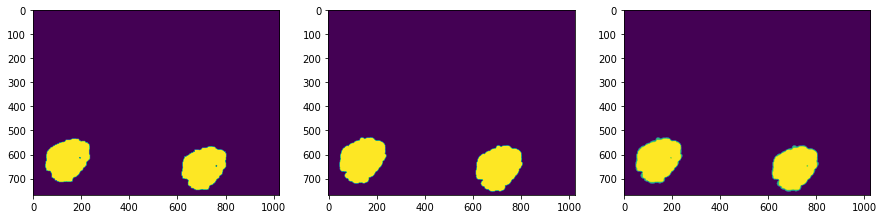

0.9553938198934865


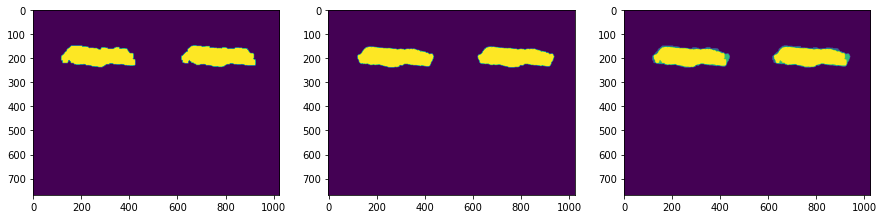

0.9281819407173229


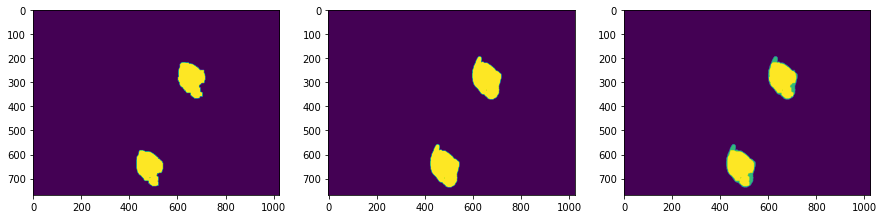

0.9023656581730676


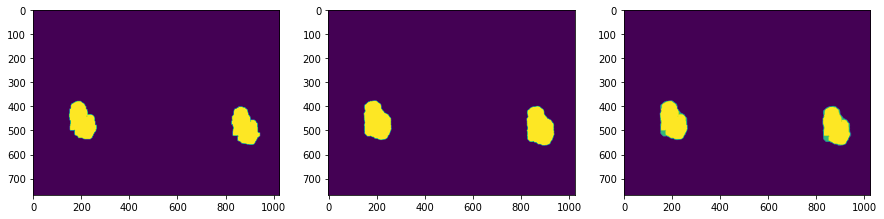

0.9395364336492891


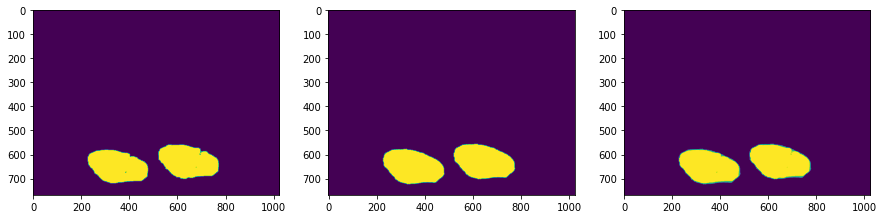

0.9687887841875431


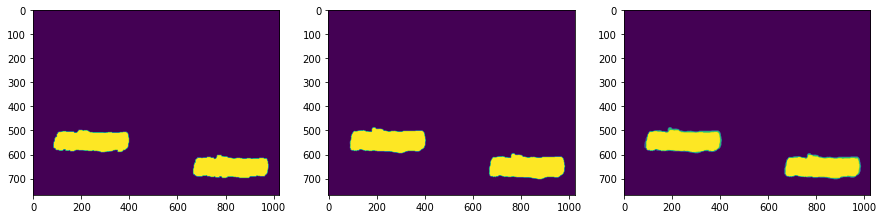

0.9433217840620056


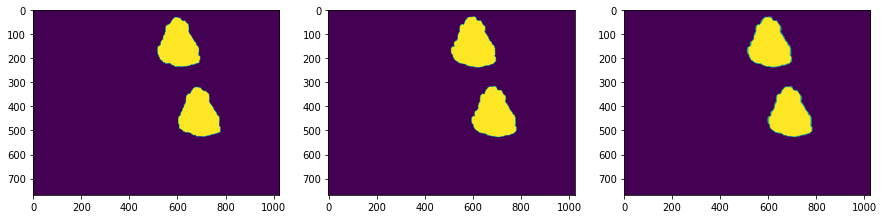

0.9600775381633148


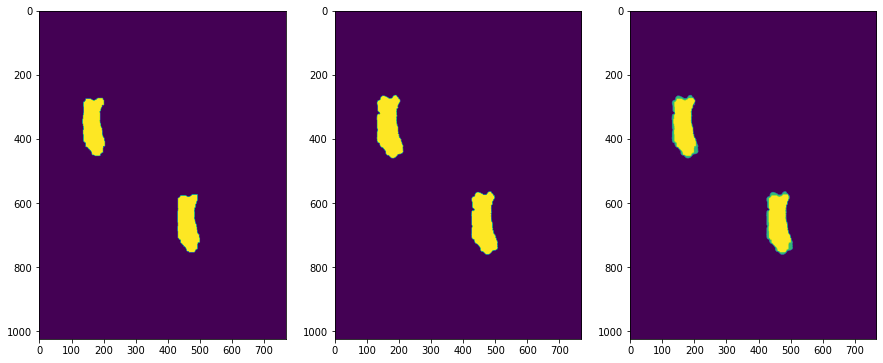

0.9020412011502381


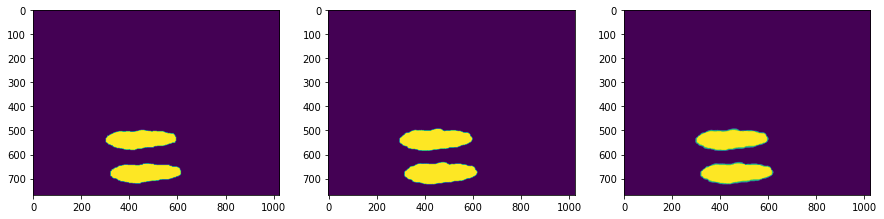

0.9331523144556504


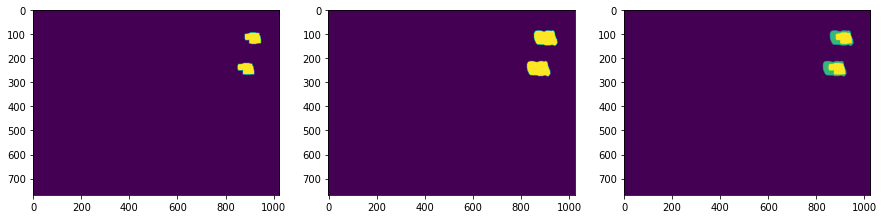

0.6727052369713593


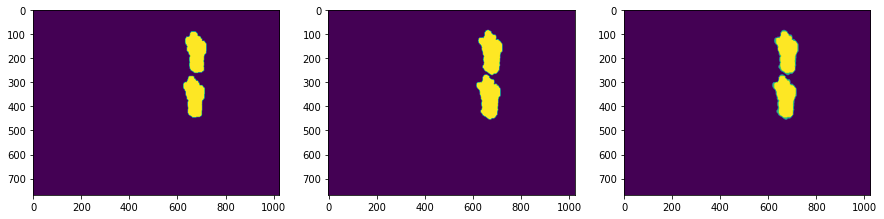

0.9276021094905007


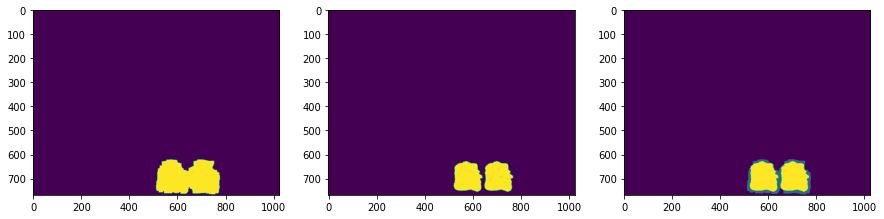

0.8585367597126417


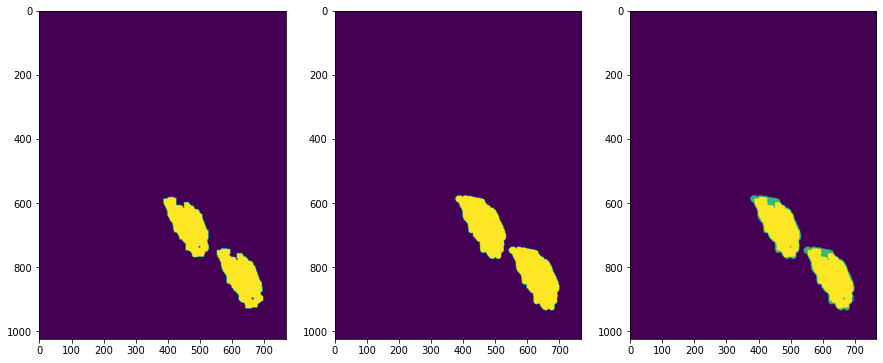

0.9196051641823122


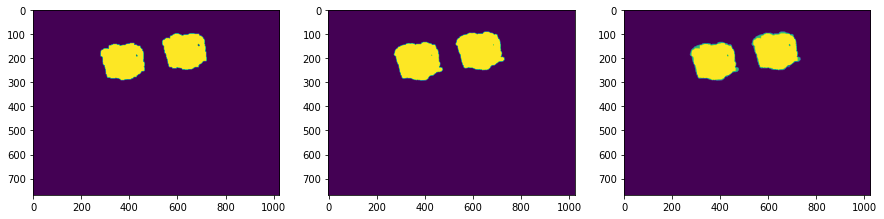

0.9554541737502421


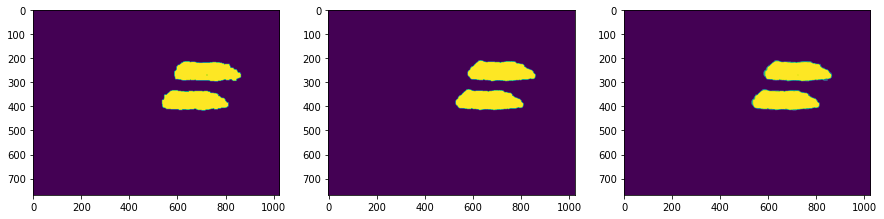

0.9674238945463386


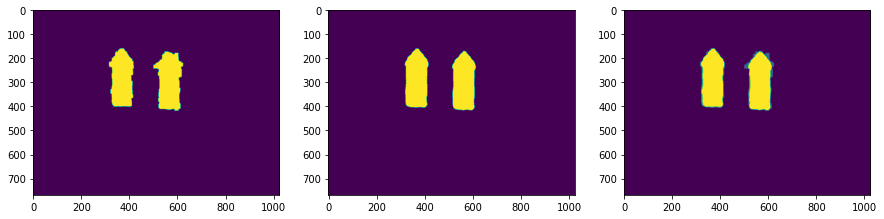

0.944798855934838


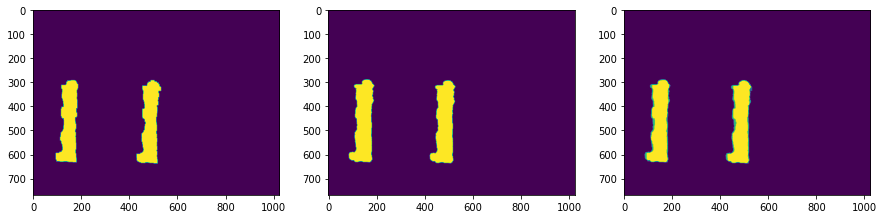

0.9335611280333599


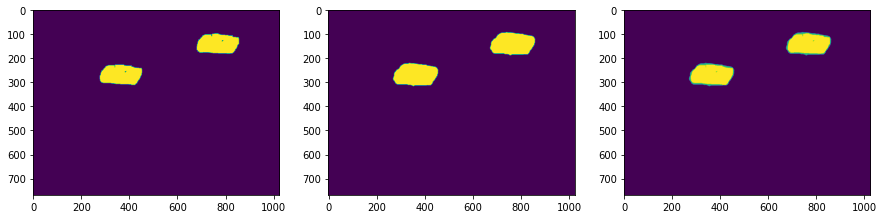

0.9199839777214031


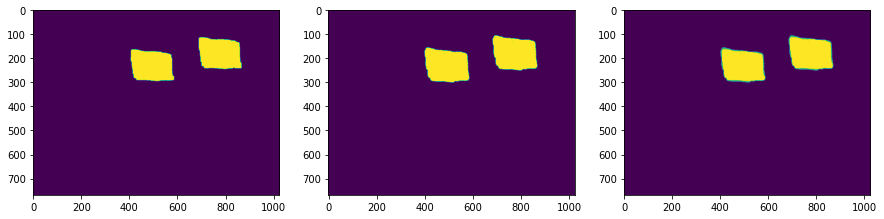

0.9525802447242419


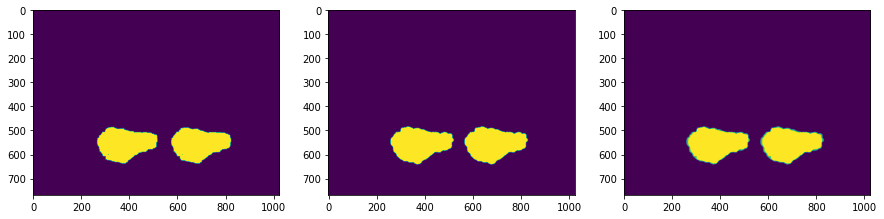

0.9626049302996923


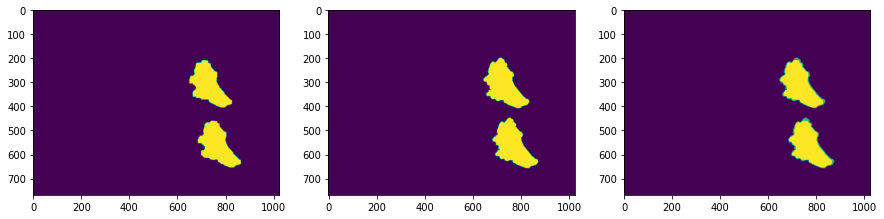

0.9409692309670451


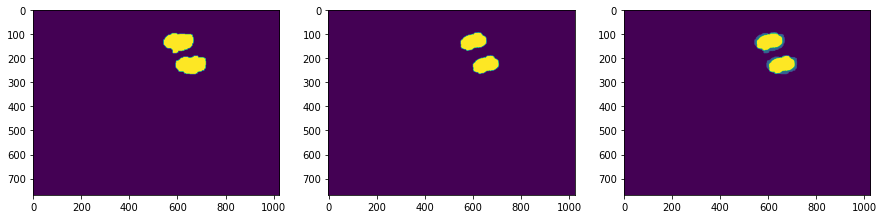

0.8332523818419578


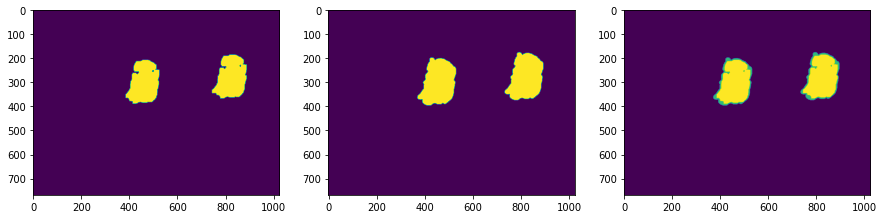

0.9068801540961897


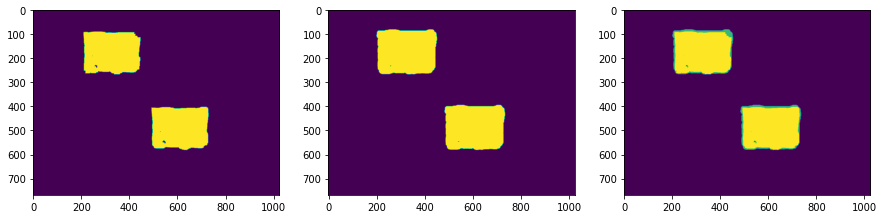

0.941417301663927


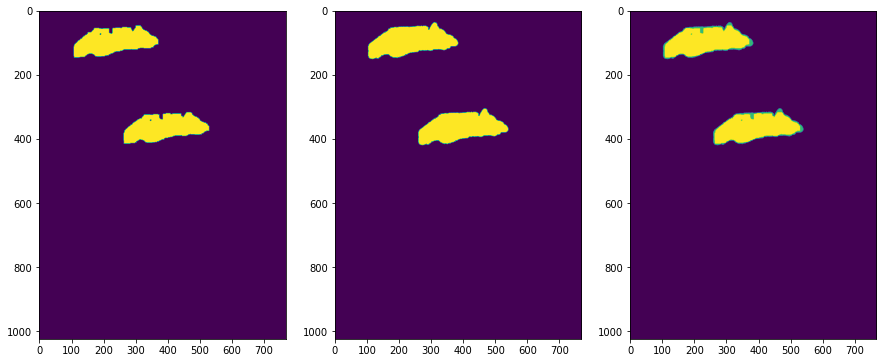

0.9328927507852975


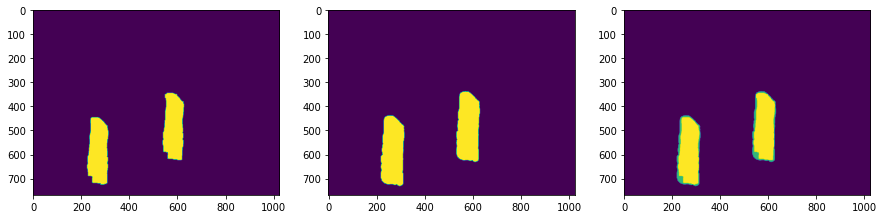

0.909602548372936


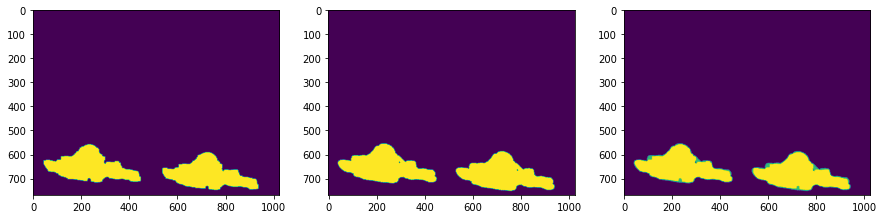

0.9539478874552639


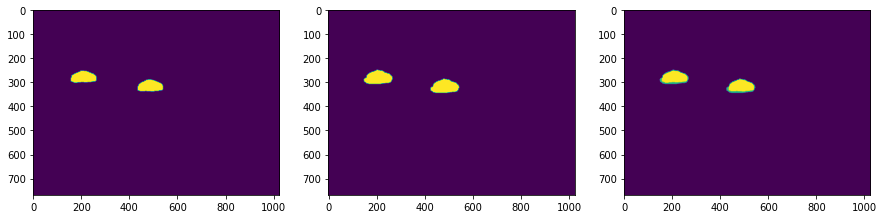

0.8853644063224901


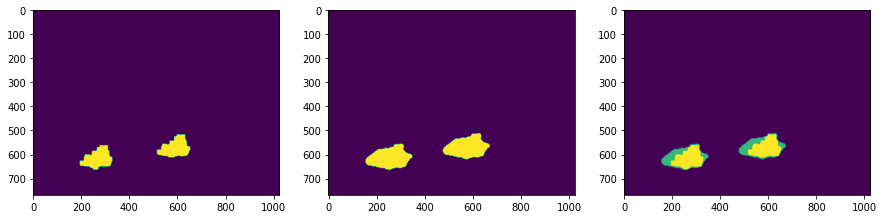

0.7659980463869517


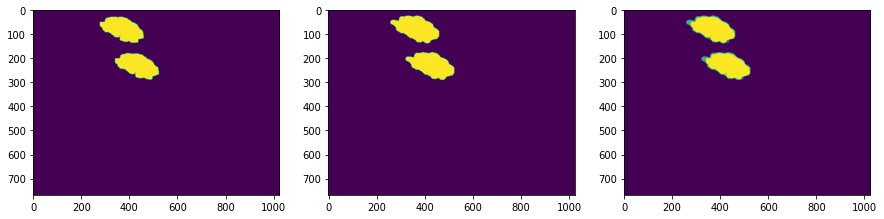

0.928358966918166


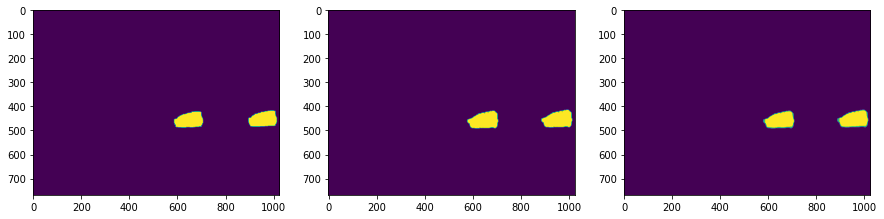

0.9381213829945095


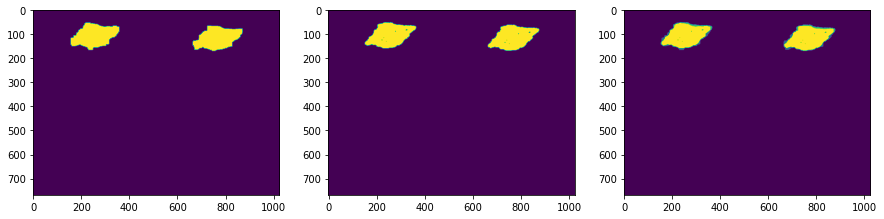

0.9328572164329001


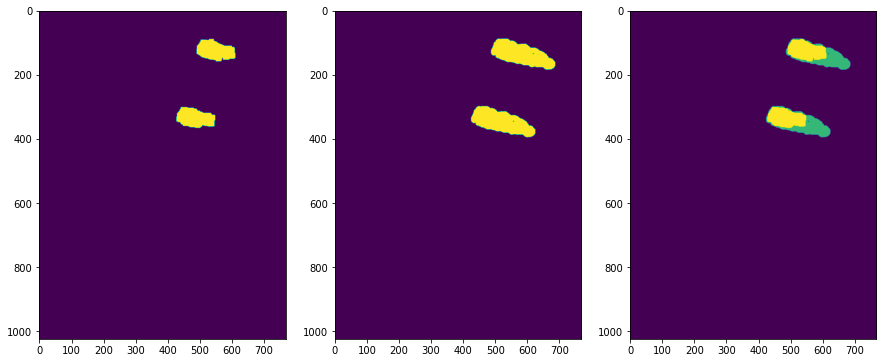

0.6932959588881102


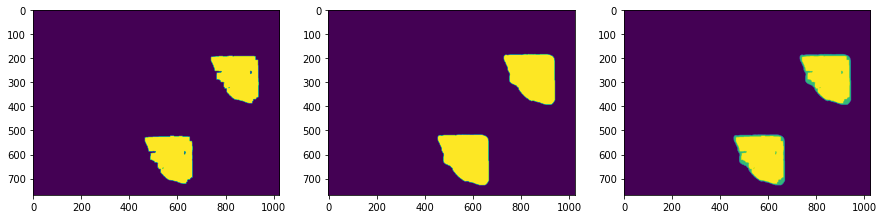

0.9154392394013982


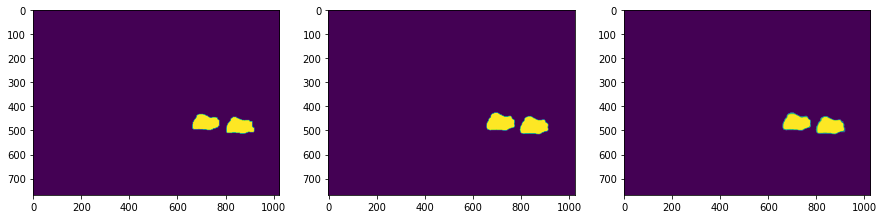

0.9271728068389986


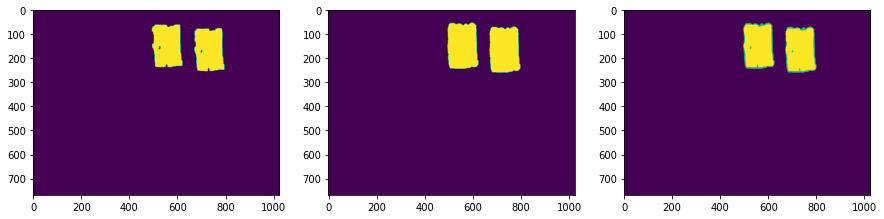

0.9319497779008318


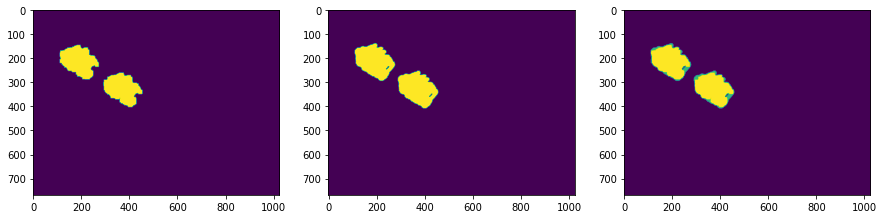

0.9314700773724933


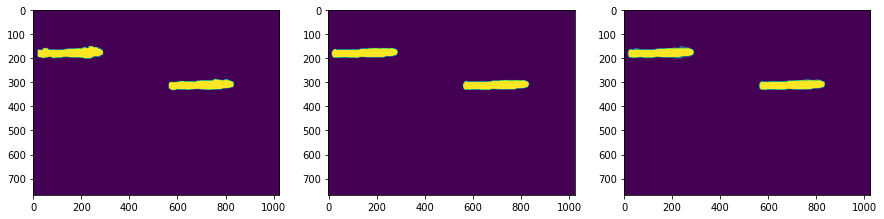

0.9503351454056052


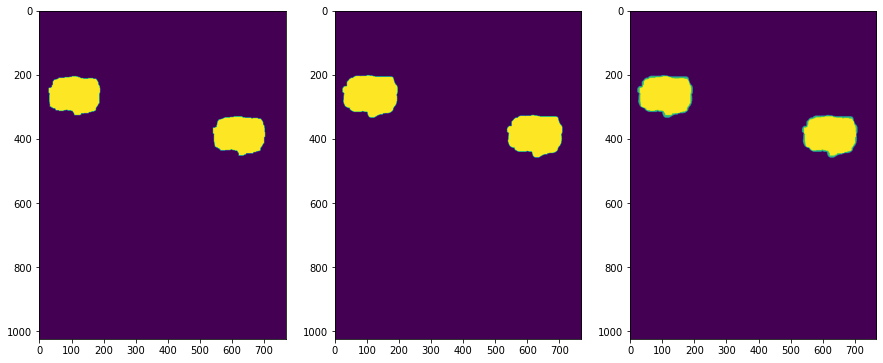

0.9374063913398087


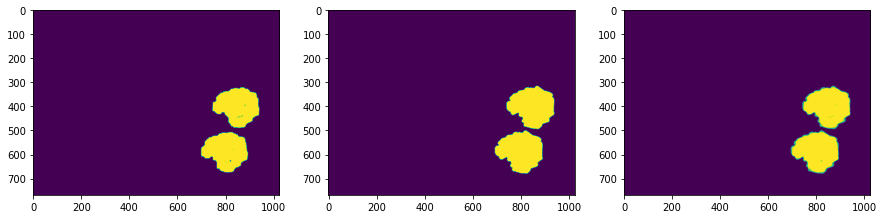

0.9534125098970705


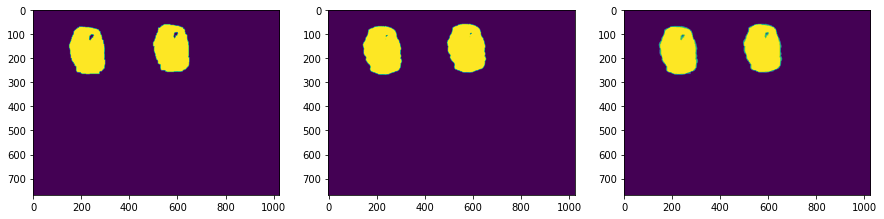

0.9590016038492382


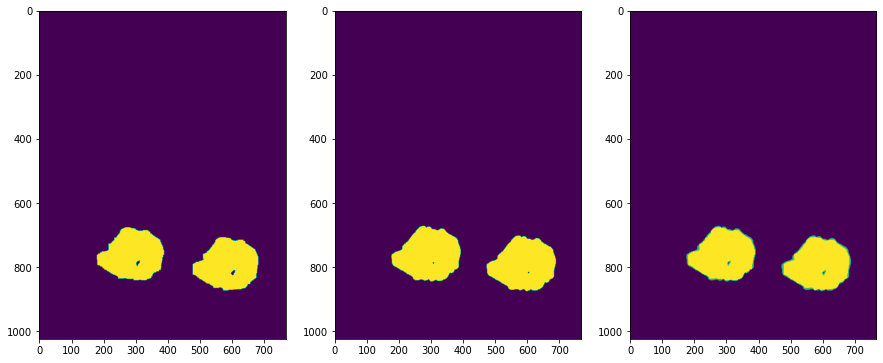

0.9612025628388369


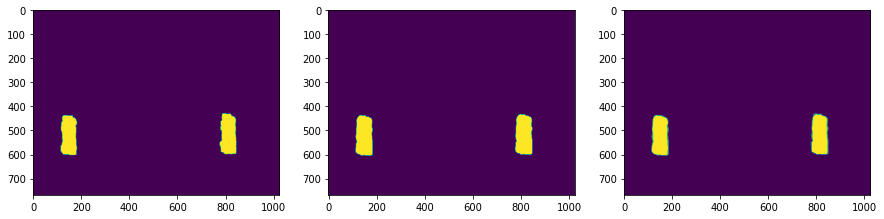

0.9370084491952567


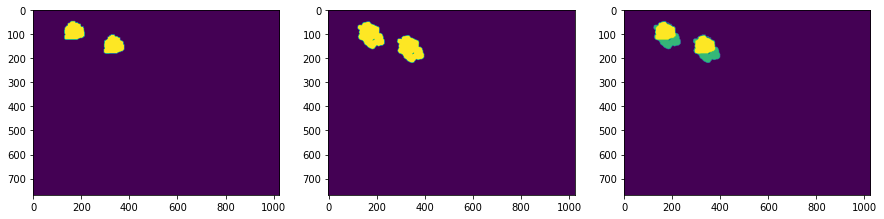

0.7303932377802279


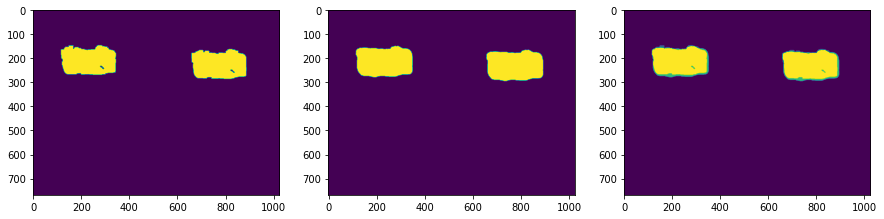

0.9342712291528181


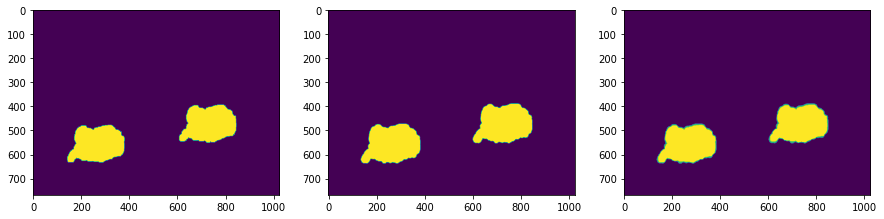

0.9559248069822088


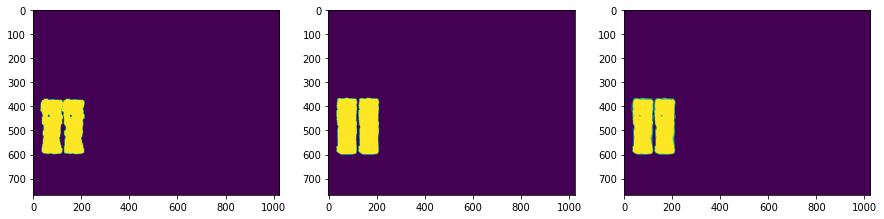

0.9504125479944449
Mean: 0.914812986978038


In [3]:
filenames = [f for f in os.listdir(RES_DIR_1) if f[:2] == "TP"]
fscores2 = []

for filename in filenames:
    res = Result(filename).compute_mask2()
    gt = res.gt
    mask = res.mask
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 9))
    ax[0].imshow(mask)
    ax[1].imshow(gt)
    ax[2].imshow(2 * gt + mask)
    plt.show()
    # Compute F measure
    TP = mask * gt
    FP = mask * (gt < 1)
    FN = (mask < 1) * gt
    
    fscore = 2 * np.sum(TP) / (2 * np.sum(TP) + np.sum(FN) + np.sum(FP))
    fscores2.append(fscore)
    print(fscore)
    
print("Mean:", np.mean(fscores2))

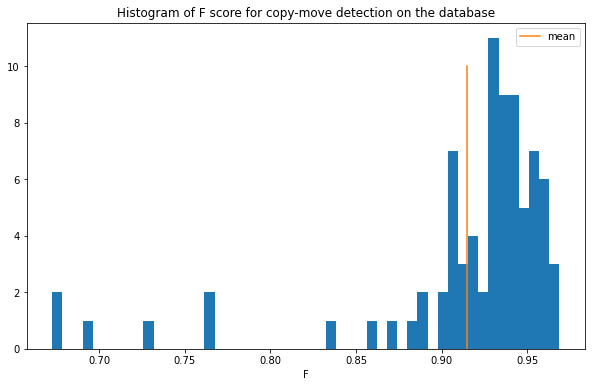

In [4]:
F2 = fscores2
plt.figure(figsize=(10,6))
plt.title("Histogram of F score for copy-move detection on the database")
plt.xlabel("F")
plt.hist(F2, bins=50)
plt.plot([np.mean(F2), np.mean(F2)], [0, 10], label="mean")
plt.legend()
plt.show()